
<font color="#6E6E6E"><h1 align="left">**Predicción de malignidad en nódulos pulmonares**</h1></font>

<h4 align="left">Vicent Muñoz Correcher</h4>

 ### Instalación e importación de librerías

In [ ]:
!pip install -q scikit-plot
!pip -q install --upgrade wandb

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import shutil
from sklearn.model_selection import train_test_split
import h5py
from tensorflow import keras
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
import wandb

### Importamos el dataset

In [ ]:
f = h5py.File('/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/data/all_patches.hdf5','r')
print(list(f.keys()))

ct_slices = f['ct_slices']
slice_class = f['slice_class']

ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)

print(ct_slices.shape)
print(slice_class.shape)

['ct_slices', 'slice_class']
(6691, 64, 64)
(6691, 1)


In [ ]:
ct_slices = ct_slices.reshape(6691,64,64,1)

X_train, X_test, y_train, y_test = train_test_split(ct_slices, slice_class, test_size=0.33, random_state=2, stratify = slice_class)

y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(X_train.shape)
print(y_train.shape)


(4482, 64, 64, 1)
(4482, 2)


### EDA: Análisis exploratorio de datos

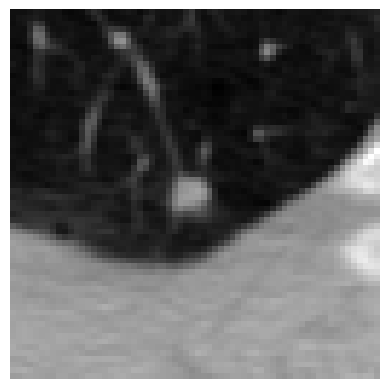

In [ ]:
index = 0
image = X_train[index]


plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

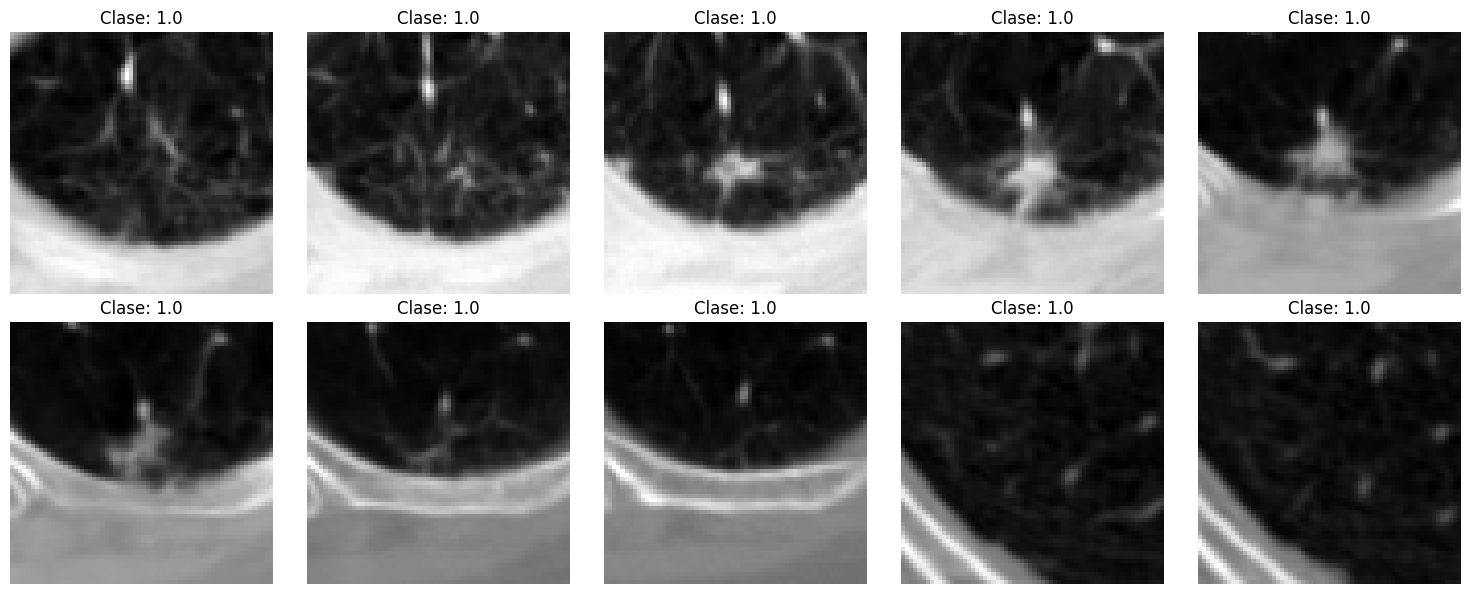

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.imshow(ct_slices[i], cmap='gray')
    ax.set_title(f"Clase: {slice_class[i][0]}")
    ax.axis('off')
plt.tight_layout()


In [ ]:
print("Estadísticas del dataset:")
print("Mínimo:", np.min(ct_slices))
print("Máximo:", np.max(ct_slices))
print("Media:", np.mean(ct_slices))
print("Desviación estándar:", np.std(ct_slices))

Estadísticas del dataset:
Mínimo: -3024.0
Máximo: 3071.0
Media: -588.6012
Desviación estándar: 407.58652


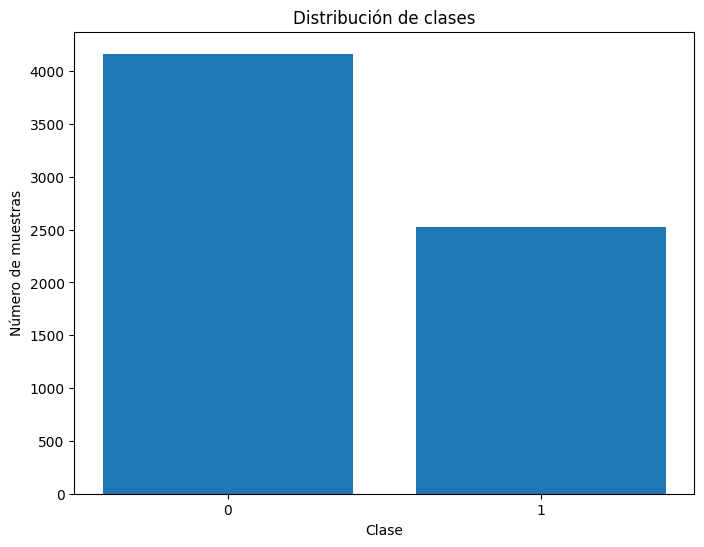

In [ ]:
# Visualización de datos
class_counts = np.unique(slice_class, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(class_counts[0], class_counts[1])
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases')
plt.xticks(class_counts[0])
plt.show()


In [ ]:

print("Distribución de clases:")
for label, count in zip(class_counts[0], class_counts[1]):
    print(f"Clase {label}: {count} muestras")

Distribución de clases:
Clase 0.0: 4165 muestras
Clase 1.0: 2526 muestras


### Propuestas de mejora y aumento de muestras del dataset (Técnicas de mejora del contraste + Data Augmentation)









En el procesamiento de imágenes, la mejora del contraste es una técnica fundamental para resaltar los detalles y mejorar la calidad visual de una imagen. El contraste se refiere a la diferencia en la intensidad entre las regiones más claras y más oscuras de una imagen. Cuando una imagen tiene un bajo contraste, es difícil distinguir entre las diferentes características y detalles presentes en ella.

Para abordar este problema, se utilizan técnicas de mejora del contraste que ajustan la distribución de intensidades de los píxeles en la imagen. Dos de estas técnicas comunes son el estiramiento de contraste y la ecualización del histograma.


- Low contrast image (Imagen de bajo contraste): Esta es la imagen de entrada original con un bajo contraste. Puede ser difícil distinguir los detalles en esta imagen debido a la falta de diferenciación entre las intensidades de los píxeles.

- Contrast stretching (Estiramiento de contraste): En esta imagen, se ha aplicado la técnica de estiramiento de contraste para ampliar el rango de intensidades de los píxeles. Esto hace que los detalles sean más visibles al aumentar el contraste entre las regiones de baja y alta intensidad.

- Histogram equalization (Ecualización del histograma): Esta imagen ha sido procesada utilizando la técnica de ecualización del histograma, que redistribuye las intensidades de los píxeles para que el histograma de la imagen sea más uniforme. Como resultado, se mejora el contraste global de la imagen y se resaltan los detalles que antes podían estar ocultos.



Los tres gráficos inferiores muestran los histogramas y las distribuciones acumulativas de intensidad correspondientes a las imágenes superiores:

Cada histograma representa la distribución de intensidades de píxeles en la imagen.
La línea roja en cada gráfico de distribución acumulativa representa la distribución acumulativa de intensidad de la imagen, mostrando cómo se distribuyen las intensidades de los píxeles en toda la imagen.
Al comparar los histogramas y las distribuciones acumulativas de intensidad de las imágenes originales y mejoradas,

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


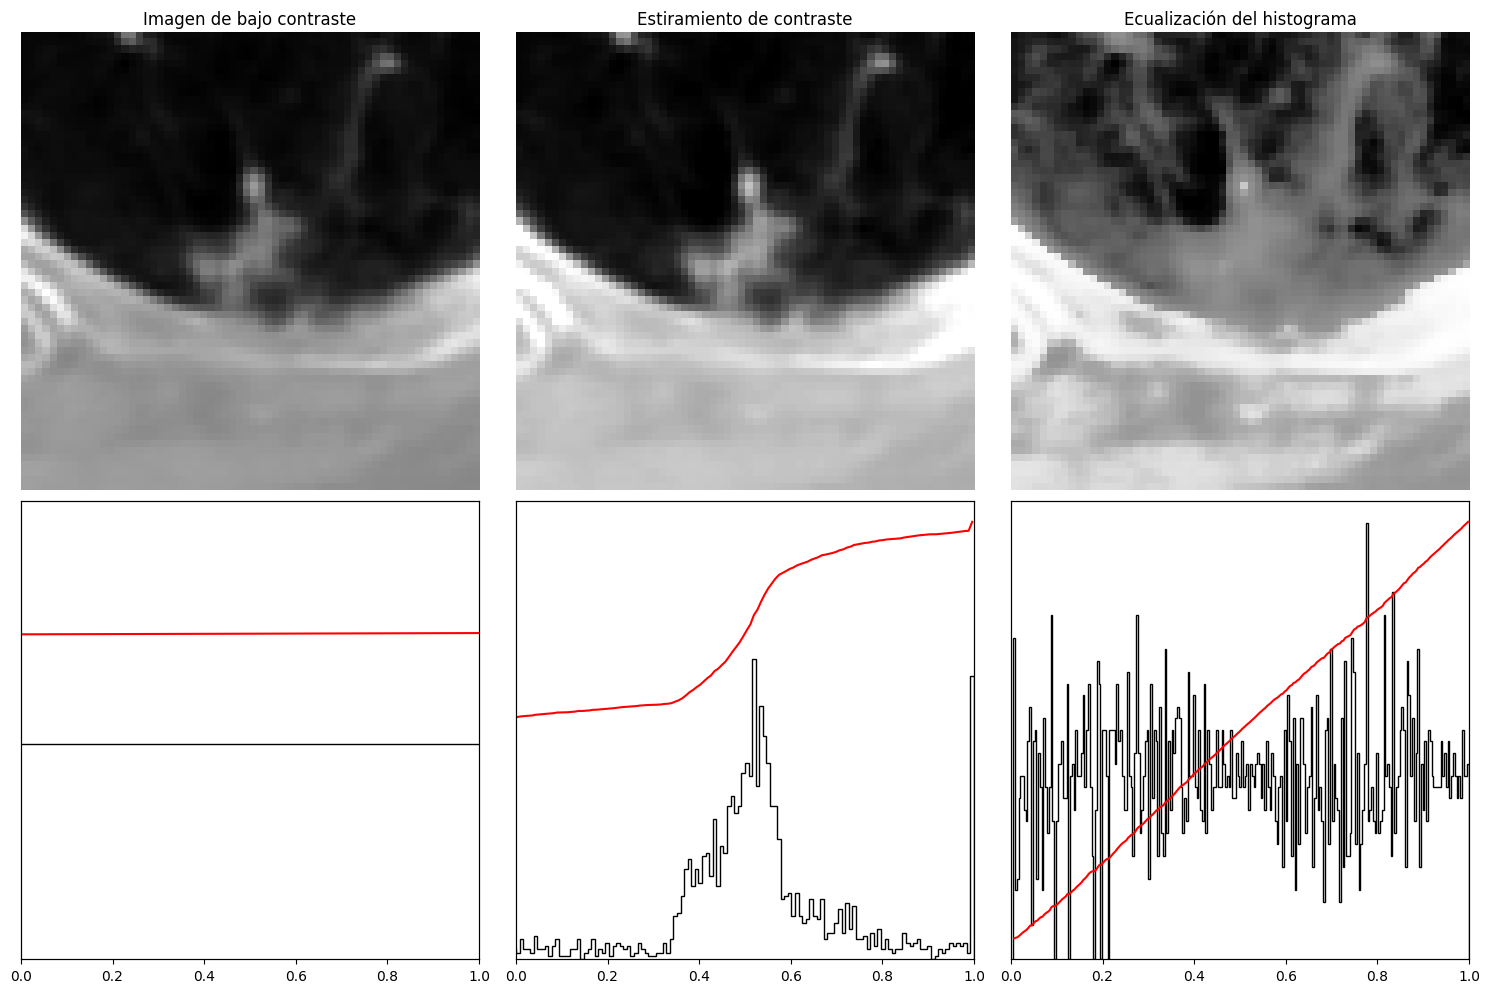

In [ ]:
def plot_img_and_hist(img, axes, title):
    """Grafica una imagen junto con su histograma y su histograma acumulativo."""
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Mostrar la imagen
    ax_img.imshow(img, cmap='gray')
    ax_img.set_axis_off()
    ax_img.set_title(title)

    # Mostrar el histograma
    ax_hist.hist(img.ravel(), bins=256, histtype='step', color='black')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Mostrar la distribución acumulativa
    img_cdf, bins = exposure.cumulative_distribution(img)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

def contrast_enhancement_demo(img):
    """Demostración de técnicas de mejora del contraste."""
    # Estiramiento de contraste
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Ecualización del histograma
    img_eq = exposure.equalize_hist(img)

    # Mostrar resultados
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plot_img_and_hist(img, axes[:, 0], 'Imagen de bajo contraste')
    plot_img_and_hist(img_rescale, axes[:, 1], 'Estiramiento de contraste')
    plot_img_and_hist(img_eq, axes[:, 2], 'Ecualización del histograma')
    fig.tight_layout()
    plt.show()


img = ct_slices[5]


contrast_enhancement_demo(img)



In [ ]:
def adaptive_histogram_equalization(images):
    """Aplica ecualización adaptativa del histograma a una lista de imágenes."""
    enhanced_images = []
    for img in images:
        img_float = img_as_float(img)
        img_normalized = (img_float - img_float.min()) / (img_float.max() - img_float.min())
        enhanced_img = exposure.equalize_adapthist(img_normalized)
        enhanced_images.append(enhanced_img)
    return enhanced_images


Al analizar las imágenes, se evidencia claramente una amplia y enriquecida gama de colores tras la aplicación de dichos métodos de mejora de contraste. Al observar los gráficos inferiores, se nota la transformación desde un histograma prácticamente plano hasta el gráfico de la izquierda en el que la intensidad de los pixeles se distribuyen mucho más.Se observa bastante mejora con la técnica de estiramiento de contraste, pero todavía más con la de ecualización del histograma. Este último revela cómo la técnica de ecualización del histograma, en particular, contribuye significativamente a la mejora del contraste de las imágenes viendo una distribución acumulativa creciente uniformemente en el gráfico.

In [ ]:
enhanced_ct_slices = adaptive_histogram_equalization(ct_slices)

In [ ]:
enhanced_ct_slices = np.array(enhanced_ct_slices)
slice_class = np.array(slice_class)


enhanced_ct_slices = enhanced_ct_slices.reshape(6691, 64, 64, 1)

# División de datos en conjuntos de entrenamiento y prueba
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(enhanced_ct_slices, slice_class, test_size=0.33, random_state=42)

# Convertir las etiquetas a una dimensión
y_train_en_flat = y_train_en.flatten()
y_test_en_flat = y_test_en.flatten()

# Convertir las etiquetas a one-hot encoding
y_train_en_one_hot = keras.utils.to_categorical(y_train_en_flat, num_classes=2)
y_test_en_one_hot = keras.utils.to_categorical(y_test_en_flat, num_classes=2)


print(X_train_en.shape)
print(y_train_en_one_hot.shape)

from google.colab import drive
drive.mount('/content/drive')
ruta_destino = '/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_en.h5'

#with h5py.File(ruta_destino, 'w') as hf:
    # Guardar los conjuntos de datos aumentados
 #   hf.create_dataset('X_train', data=X_train_en)
  #  hf.create_dataset('y_train', data=y_train_en_one_hot)
   # hf.create_dataset('X_test', data=X_test_en)
    #hf.create_dataset('y_test', data=y_test_en_one_hot)

#print("Datos aumentados guardados exitosamente en", ruta_destino)




(4482, 64, 64, 1)
(4482, 2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datos aumentados guardados exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_en.h5


In [ ]:
def contrast_stretching(images):
    """Aplica estiramiento de contraste a una lista de imágenes."""
    enhanced_images = []
    for img in images:
        p2, p98 = np.percentile(img, (2, 98))
        enhanced_img = exposure.rescale_intensity(img, in_range=(p2, p98))
        enhanced_images.append(enhanced_img)
    return enhanced_images

# Aplicar estiramiento de contraste a las imágenes de CT
enhanced_ct_slices_contrast_stretching = contrast_stretching(ct_slices)

# Convertir a formato numpy array
enhanced_ct_slices_contrast_stretching = np.array(enhanced_ct_slices_contrast_stretching)

# Reorganizar las dimensiones si es necesario
enhanced_ct_slices_contrast_stretching = enhanced_ct_slices_contrast_stretching.reshape(6691, 64, 64, 1)

# División de datos en conjuntos de entrenamiento y prueba
X_train_contrast_stretching, X_test_contrast_stretching, y_train_contrast_stretching, y_test_contrast_stretching = train_test_split(enhanced_ct_slices_contrast_stretching, slice_class, test_size=0.33, random_state=42)

# Convertir las etiquetas a one-hot encoding
y_train_contrast_stretching = keras.utils.to_categorical(y_train_contrast_stretching, num_classes=2)
y_test_contrast_stretching = keras.utils.to_categorical(y_test_contrast_stretching, num_classes=2)

# Imprimir formas de conjuntos de entrenamiento
print(X_train_contrast_stretching.shape)
print(y_train_contrast_stretching.shape)


(4482, 64, 64, 1)
(4482, 2)


In [ ]:

datagen = ImageDataGenerator(
    rotation_range=20,            # Rango de rotación aleatoria
    width_shift_range=0.1,        # Rango de traslación horizontal aleatoria
    height_shift_range=0.1,       # Rango de traslación vertical aleatoria
    shear_range=0.2,              # Rango de corte (shear) aleatorio
    zoom_range=0.2,               # Rango de zoom aleatorio
    horizontal_flip=True,         # Volteo horizontal aleatorio
    vertical_flip=True,           # Volteo vertical aleatorio
    fill_mode='nearest'           # Modo de relleno para píxeles nuevos generados
)


def apply_augmentation(datagen, X_data, y_data):
    augmented_X_data = []
    augmented_y_data = []

    # Iterar sobre cada imagen en el conjunto de datos
    for i in range(len(X_data)):
        # Expandir la dimensión del lote (batch) para el generador de datos
        image = X_data[i].reshape((1,) + X_data[i].shape)
        # Generar imágenes aumentadas
        for batch in datagen.flow(image, batch_size=1):
            augmented_X_data.append(batch.reshape(X_data[i].shape))  # Añadir la imagen aumentada a la lista
            augmented_y_data.append(y_data[i])  # Añadir la etiqueta correspondiente
            if len(augmented_X_data) % 10 == 0:  # Genera 10 imágenes aumentadas por cada imagen original
                break


    augmented_X_data = np.array(augmented_X_data)
    augmented_y_data = np.array(augmented_y_data)

    return augmented_X_data, augmented_y_data


augmented_X_train_orig, augmented_y_train_orig = apply_augmentation(datagen, X_train, y_train)
#augmented_X_train_enhanced_adapt, augmented_y_train_enhanced_adapt = apply_augmentation(datagen, X_train_en, y_train_en_one_hot)
#augmented_X_train_enhanced_contrast, augmented_y_train_enhanced_contrast = apply_augmentation(datagen, X_train_contrast_stretching, y_train_contrast_stretching)

# Concatenar los conjuntos de datos aumentados
#augmented_X_train = np.concatenate((augmented_X_train_orig, augmented_X_train_enhanced_adapt, augmented_X_train_enhanced_contrast), axis=0)
#augmented_y_train = np.concatenate((augmented_y_train_orig, augmented_y_train_enhanced_adapt, augmented_y_train_enhanced_contrast), axis=0)

# Verificar las dimensiones del nuevo conjunto de datos aumentado
#print("Dimensiones del nuevo conjunto de datos aumentado:")
#print("X_train:", augmented_X_train.shape)
#print("y_train:", augmented_y_train.shape)

#print("Dimensiones del conjunto de datos aumentado del dataset original:")
print("X_train:", augmented_X_train_orig.shape)
print("y_train:", augmented_y_train_orig.shape)



X_train: (44820, 64, 64, 1)
y_train: (44820, 2)


In [ ]:
#import h5py
#from keras.utils import to_categorical

#ruta_destino = '/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_aumentados_orig.h5'

#with h5py.File(ruta_destino, 'w') as hf:
    # Guardar los conjuntos de datos aumentados
 #   hf.create_dataset('X_train', data=augmented_X_train_orig)
  #  hf.create_dataset('y_train', data=augmented_y_train_orig)

#print("Datos aumentados guardados exitosamente en", ruta_destino)



Datos aumentados guardados exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_aumentados_orig.h5


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#ruta_destino = '/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_aumentados_orig.h5'
#with h5py.File(ruta_destino, 'w') as hf:
     #Guardar los conjuntos de datos aumentados
 #    hf.create_dataset('X_train', data=augmented_X_train_orig)
 #    hf.create_dataset('y_train', data=augmented_X_train_orig)

#print("Datos aumentados guardados exitosamente en", ruta_destino)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datos aumentados guardados exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_aumentados_orig.h5


In [ ]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

### Entrenamiento Dataset Original


#### Configuración WandB

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True


#### Modelo básico: Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

X_tr_rs = X_train.reshape(len(X_train), -1)
X_te_rs = X_test.reshape(len(X_test), -1)
Y_tr_rs = y_train.reshape(len(X_train), -1)
Y_te_rs = y_test.reshape(len(X_test), -1)

modelLogReg = LogisticRegression()
modelLogReg.fit(X_tr_rs, np.argmax(y_train,1))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print('Train accuracy:', modelLogReg.score(X_tr_rs, np.argmax(Y_tr_rs,1)))
print('Test accuracy :', modelLogReg.score(X_te_rs, np.argmax(Y_te_rs,1)))

Train accuracy: 0.8257474341811691
Test accuracy : 0.7587143503847895


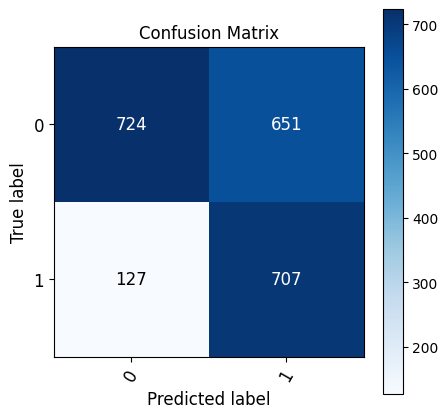

In [ ]:
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(Y_te_rs.argmax(1),
                      modelLogReg.predict_proba(X_te_rs)[:,1] > 0.2,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

#### Basic ConvNet with Pooling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                   

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"

# Guarda el archivo JSON
model_json = model.to_json()
with open(os.path.join(ruta_modelo, "model.json"), "w") as json_file:
    json_file.write(model_json)
print("Modelo guardado exitosamente en", ruta_modelo)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datos aumentados guardados exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


Epoch 1/50
71/71 [==============================] - 19s 89ms/step - loss: 2.2813 - accuracy: 0.5834 - val_loss: 0.6791 - val_accuracy: 0.6125
Epoch 2/50
71/71 [==============================] - 3s 39ms/step - loss: 0.6298 - accuracy: 0.6457 - val_loss: 0.6162 - val_accuracy: 0.6668
Epoch 3/50
71/71 [==============================] - 2s 30ms/step - loss: 0.6234 - accuracy: 0.6598 - val_loss: 0.5963 - val_accuracy: 0.6899
Epoch 4/50
71/71 [==============================] - 2s 29ms/step - loss: 0.5963 - accuracy: 0.6792 - val_loss: 0.6248 - val_accuracy: 0.6532
Epoch 5/50
71/71 [==============================] - 2s 30ms/step - loss: 0.5902 - accuracy: 0.6921 - val_loss: 0.5765 - val_accuracy: 0.7397
Epoch 6/50
71/71 [==============================] - 2s 31ms/step - loss: 0.5547 - accuracy: 0.7227 - val_loss: 0.5409 - val_accuracy: 0.7365
Epoch 7/50
71/71 [==============================] - 3s 37ms/step - loss: 0.5378 - accuracy: 0.7314 - val_loss: 0.5186 - val_accuracy: 0.7447
Epoch 8/50
7

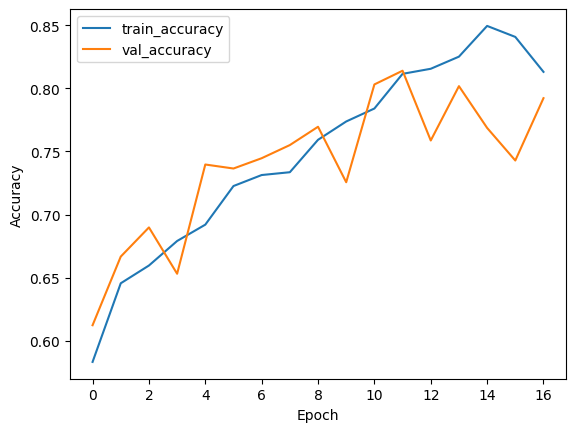

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])




plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Basic ConvNet with Pooling (WandB Simple)


In [ ]:
import random
import numpy as np
import tensorflow as tf
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


wandb.init(project="ConvNetChetada", config={
    "learning_rate": random.uniform(0.001, 0.1),
    "dropout_rate": random.uniform(0.2, 0.5),
    "optimizer": "adam",
    "epochs": 50,
    "batch_size": 64,
})
config = wandb.config

model.compile(optimizer=config.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])




wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
]

model.fit(
    x=X_train,
    y=y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(X_test, y_test),
    callbacks=wandb_callbacks,
)


wandb.finish()


wandb: Currently logged in as: coralanaliticas. Use `wandb login --relogin` to force relogin


Epoch 1/50


KeyboardInterrupt: 

#### Basic ConvNet with Pooling (WandB Random Search)

In [ ]:
import random
import numpy as np
import tensorflow as tf
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


sweep_config = {
    'method': 'random'
    }
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    }

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)




{'method': 'random',
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ConvNetChetadaAgent")

Create sweep with ID: 5dwpcq2m
Sweep URL: https://wandb.ai/coralanaliticas/ConvNetChetadaAgent/sweeps/5dwpcq2m


In [ ]:
from wandb.keras import WandbCallback

def train():

    for _ in range(10):

        config_defaults = {
            'optimizer': random.choice(sweep_config['parameters']['optimizer']['values']),
            'dropout': random.choice(sweep_config['parameters']['dropout']['values']),
            'learning_rate': random.uniform(sweep_config['parameters']['learning_rate']['min'],
                                            sweep_config['parameters']['learning_rate']['max']),
            'batch_size': int(random.randint(sweep_config['parameters']['batch_size']['min'],
                                              sweep_config['parameters']['batch_size']['max']))
        }


        wandb.init(config=config_defaults)

        model.compile(optimizer=config_defaults['optimizer'],
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])


        model.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=config_defaults['batch_size'],
                  callbacks=[WandbCallback()])


wandb.agent(sweep_id, function=train)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


14/19 [=====================>........] - ETA: 25s - loss: nan - accuracy: 0.6238

wandb: Agent Starting Run: c5fj3kix with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.4
wandb: 	learning_rate: 0.09975366010668169
wandb: 	optimizer: sgd


15/19 [======================>.......] - ETA: 22s - loss: nan - accuracy: 0.6268

Epoch 1/50
19/19 [==============================] - 120s 6s/step - loss: nan - accuracy: 0.6093
Epoch 7/10
17/31 [===============>..............] - ETA: 1:34 - loss: nan - accuracy: 0.6330

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x79f724991090>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

#### U-net

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense


def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dense = Dense(2, activation='softmax')(flatten)


    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"

model_json = model.to_json()
with open(os.path.join(ruta_modelo, "model_Unet.json"), "w") as json_file:
    json_file.write(model_json)
print("Modelo guardado exitosamente en", ruta_modelo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50
71/71 [==============================] - 50s 249ms/step - loss: 186.2599 - accuracy: 0.5689 - val_loss: 0.6895 - val_accuracy: 0.5201
Epoch 2/50
71/71 [==============================] - 13s 180ms/step - loss: 0.6060 - accuracy: 0.6834 - val_loss: 0.5754 - val_accuracy: 0.7062
Epoch 3/50
71/71 [==============================] - 13s 180ms/step - loss: 0.5039 - accuracy: 0.7606 - val_loss: 0.5484 - val_accuracy: 0.7202
Epoch 4/50
71/71 [==============================] - 13s 179ms/step - loss: 0.4471 - accuracy: 0.7945 - val_loss: 0.5270 - val_accuracy: 0.7537
Epoch 5/50
71/71 [==============================] - 13s 177ms/step - loss: 0.3818 - accuracy: 0.8327 - val_loss: 0.5641 - val_accuracy: 0.7524
Epoch 6/50
71/71 [==============================] - 13s 178ms/step - loss: 0.3017 - accuracy: 0.8650 - val_loss: 0.5682 - val_accuracy: 0.7746
Epoch 7/50
71/71 [==============================] - 13s 189ms/step - loss: 0.2612 - accuracy: 0.8853 - val_loss: 0.6044 - val_accuracy: 0.79

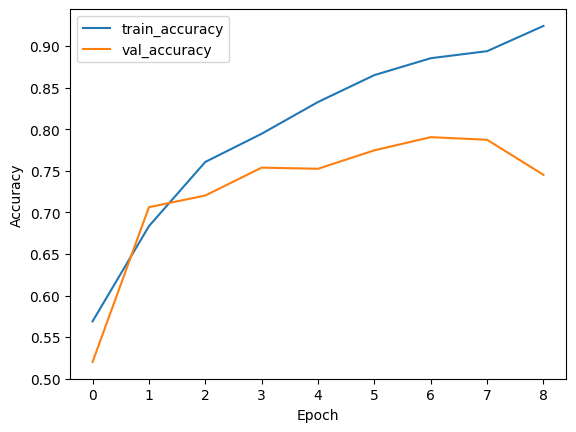

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


  U-Net 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers


def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dense = Dense(2, activation='softmax')(flatten)


    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
from google.colab import drive

drive.mount("/content/drive")


ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"


model_json = model.to_json()
with open(os.path.join(ruta_modelo, "model_Unet2.json"), "w") as json_file:
    json_file.write(model_json)
print("Modelo guardado exitosamente en", ruta_modelo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


Epoch 1/50
71/71 [==============================] - 22s 203ms/step - loss: 6.3151 - accuracy: 0.6568 - val_loss: 1505.1932 - val_accuracy: 0.3775
Epoch 2/50
71/71 [==============================] - 14s 196ms/step - loss: 6.1281 - accuracy: 0.6923 - val_loss: 138.6450 - val_accuracy: 0.3843
Epoch 3/50
71/71 [==============================] - 14s 199ms/step - loss: 3.2905 - accuracy: 0.7715 - val_loss: 117.6472 - val_accuracy: 0.4065
Epoch 4/50
71/71 [==============================] - 15s 209ms/step - loss: 1.8492 - accuracy: 0.8382 - val_loss: 18.2479 - val_accuracy: 0.4672
Epoch 5/50
71/71 [==============================] - 14s 199ms/step - loss: 1.6899 - accuracy: 0.8661 - val_loss: 7.0962 - val_accuracy: 0.7067
Epoch 6/50
71/71 [==============================] - 15s 205ms/step - loss: 1.4397 - accuracy: 0.8851 - val_loss: 4.6481 - val_accuracy: 0.6922
Epoch 7/50
71/71 [==============================] - 14s 195ms/step - loss: 1.8518 - accuracy: 0.8481 - val_loss: 6.9078 - val_accuracy

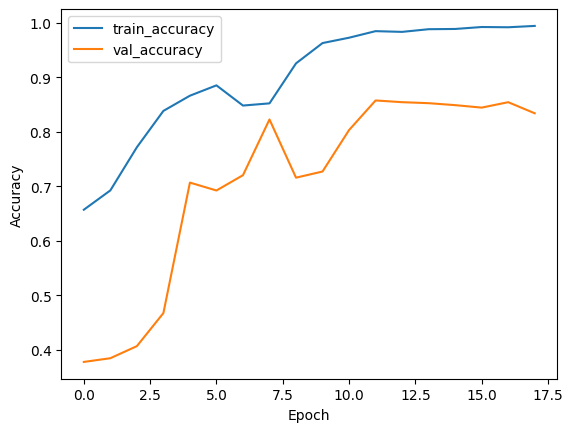

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


U-Net 3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Definir la arquitectura U-Net
def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dropout = Dropout(0.5)(flatten)
    dense = Dense(2, activation='softmax')(dropout)


    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from google.colab import drive

drive.mount("/content/drive")


ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"


model_json = model.to_json()
with open(os.path.join(ruta_modelo, "model_Unet3.json"), "w") as json_file:
    json_file.write(model_json)
print("Modelo guardado exitosamente en", ruta_modelo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


Epoch 1/50
71/71 [==============================] - 25s 217ms/step - loss: 6.3981 - accuracy: 0.6328 - val_loss: 61.8661 - val_accuracy: 0.4382
Epoch 2/50
71/71 [==============================] - 14s 200ms/step - loss: 3.9879 - accuracy: 0.6961 - val_loss: 16.4132 - val_accuracy: 0.4337
Epoch 3/50
71/71 [==============================] - 14s 202ms/step - loss: 3.0357 - accuracy: 0.7657 - val_loss: 9.7417 - val_accuracy: 0.5242
Epoch 4/50
71/71 [==============================] - 14s 199ms/step - loss: 2.2140 - accuracy: 0.8005 - val_loss: 13.4220 - val_accuracy: 0.6075
Epoch 5/50
71/71 [==============================] - 15s 208ms/step - loss: 2.0331 - accuracy: 0.8242 - val_loss: 6.8262 - val_accuracy: 0.6809
Epoch 6/50
71/71 [==============================] - 15s 207ms/step - loss: 1.3720 - accuracy: 0.8675 - val_loss: 7.7932 - val_accuracy: 0.7085
Epoch 7/50
71/71 [==============================] - 15s 208ms/step - loss: 1.9722 - accuracy: 0.8487 - val_loss: 3.8642 - val_accuracy: 0.7

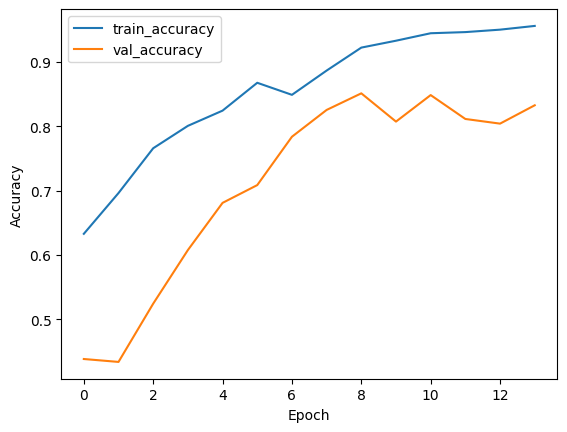

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dropout = Dropout(0.6)(flatten)
    dense = Dense(2, activation='softmax')(dropout)


    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from google.colab import drive

drive.mount("/content/drive")


ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"


model_json = model.to_json()
with open(os.path.join(ruta_modelo, "model_Unet4.json"), "w") as json_file:
    json_file.write(model_json)
print("Modelo guardado exitosamente en", ruta_modelo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


Epoch 1/50
71/71 [==============================] - 24s 252ms/step - loss: 5.3834 - accuracy: 0.6343 - val_loss: 3779.5527 - val_accuracy: 0.3789
Epoch 2/50
71/71 [==============================] - 17s 244ms/step - loss: 4.3851 - accuracy: 0.7193 - val_loss: 124.4693 - val_accuracy: 0.3821
Epoch 3/50
71/71 [==============================] - 17s 247ms/step - loss: 4.5773 - accuracy: 0.7247 - val_loss: 43.5375 - val_accuracy: 0.4604
Epoch 4/50
71/71 [==============================] - 18s 249ms/step - loss: 3.5440 - accuracy: 0.7673 - val_loss: 13.0736 - val_accuracy: 0.6442
Epoch 5/50
71/71 [==============================] - 17s 243ms/step - loss: 2.2189 - accuracy: 0.8017 - val_loss: 9.7739 - val_accuracy: 0.7030
Epoch 6/50
71/71 [==============================] - 16s 232ms/step - loss: 2.3851 - accuracy: 0.8075 - val_loss: 11.1484 - val_accuracy: 0.6976
Epoch 7/50
71/71 [==============================] - 17s 243ms/step - loss: 1.7434 - accuracy: 0.8362 - val_loss: 2.3010 - val_accuracy

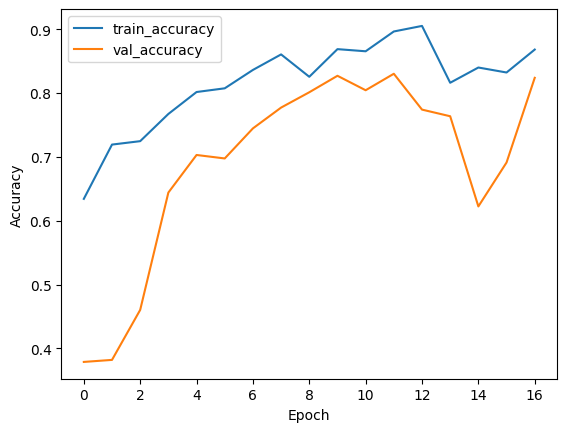

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Inception Net (GoogleNet)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Dense, Flatten, AveragePooling2D
from tensorflow.keras.models import Model

def inception_module(x, filters):

    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)


    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', activation='relu')(x)


    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), padding='same', activation='relu')(x)


    max_pooling = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    max_pooling_conv = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(max_pooling)


    concatenated = concatenate([conv1x1, conv3x3, conv5x5, max_pooling_conv], axis=-1)

    return concatenated

def inception_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, filters=[64, 128, 32, 32])
    x = inception_module(x, filters=[128, 192, 96, 64])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, filters=[192, 208, 48, 64])
    x = inception_module(x, filters=[160, 224, 64, 64])
    x = inception_module(x, filters=[128, 256, 64, 64])
    x = inception_module(x, filters=[112, 288, 64, 64])
    x = inception_module(x, filters=[256, 320, 128, 128])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Flatten
    x = Flatten()(x)

    # Dropout
    x = Dropout(0.4)(x)

    # Dense layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (64, 64, 1)
num_classes = 2


model = inception_net(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           4160      ['max_pooling2d[0][0]']   

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"


model_json = model.to_json()
with open(os.path.join(ruta_modelo, "model_InceptionNet.json"), "w") as json_file:
    json_file.write(model_json)
print("Modelo guardado exitosamente en", ruta_modelo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


Epoch 1/20
141/141 [==============================] - 28s 69ms/step - loss: 22.5408 - accuracy: 0.6040 - val_loss: 0.6489 - val_accuracy: 0.6229
Epoch 2/20
141/141 [==============================] - 6s 39ms/step - loss: 0.6383 - accuracy: 0.6455 - val_loss: 0.7891 - val_accuracy: 0.3975
Epoch 3/20
141/141 [==============================] - 6s 41ms/step - loss: 0.5880 - accuracy: 0.6957 - val_loss: 0.5070 - val_accuracy: 0.7637
Epoch 4/20
141/141 [==============================] - 5s 36ms/step - loss: 0.5012 - accuracy: 0.7651 - val_loss: 0.4635 - val_accuracy: 0.7986
Epoch 5/20
141/141 [==============================] - 5s 37ms/step - loss: 0.4631 - accuracy: 0.7945 - val_loss: 0.4192 - val_accuracy: 0.8189
Epoch 6/20
141/141 [==============================] - 6s 40ms/step - loss: 0.3874 - accuracy: 0.8311 - val_loss: 0.6589 - val_accuracy: 0.7288
Epoch 7/20
141/141 [==============================] - 6s 40ms/step - loss: 0.3760 - accuracy: 0.8385 - val_loss: 0.4105 - val_accuracy: 0.82

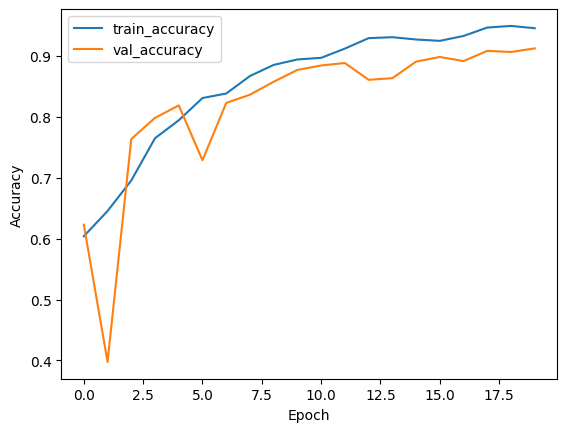

In [ ]:


history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test, y_test))


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Entrenamiento Dataset Mejoras del contraste


#### Dataset

In [ ]:
import h5py

ruta_archivo = '/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_en.h5'

with h5py.File(ruta_archivo, 'r') as f:

    X_train = f['X_train'][:]
    y_train = f['y_train'][:]


print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)



Forma de X_train: (4482, 64, 64, 1)
Forma de y_train: (4482, 2)


In [ ]:
with h5py.File(ruta_archivo, 'r') as f:
    print("Llaves en el archivo HDF5:", list(f.keys()))

Llaves en el archivo HDF5: ['X_test', 'X_train', 'y_test', 'y_train']


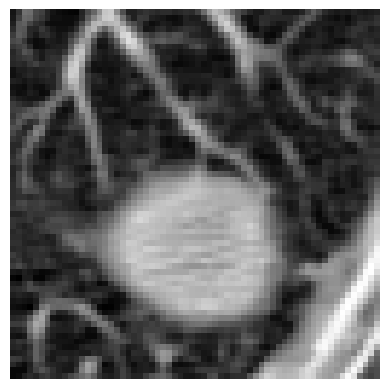

In [ ]:
image = X_train[5]

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()


#### Modelo básico: Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

X_tr_rs = X_train.reshape(len(X_train), -1)
X_te_rs = X_test.reshape(len(X_test), -1)
Y_tr_rs = y_train.reshape(len(X_train), -1)
Y_te_rs = y_test.reshape(len(X_test), -1)

modelLogReg = LogisticRegression()
modelLogReg.fit(X_tr_rs, np.argmax(y_train,1))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print('Train accuracy:', modelLogReg.score(X_tr_rs, np.argmax(Y_tr_rs,1)))
print('Test accuracy :', modelLogReg.score(X_te_rs, np.argmax(Y_te_rs,1)))

Train accuracy: 0.9384203480589023
Test accuracy : 0.5355364418288818


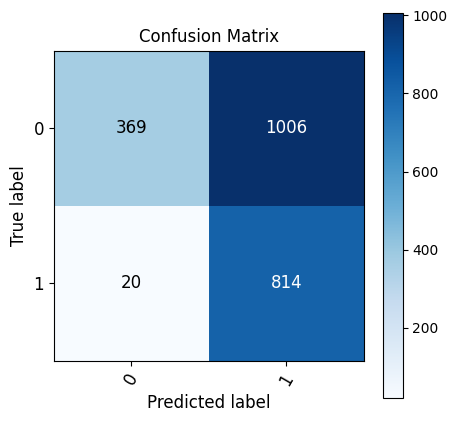

In [ ]:
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(Y_te_rs.argmax(1),
                      modelLogReg.predict_proba(X_te_rs)[:,1] > 0.2,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

#### Basic ConvNet with Pooling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                   

Epoch 1/20
71/71 [==============================] - 2s 23ms/step - loss: 0.4949 - accuracy: 0.7519 - val_loss: 93594.2422 - val_accuracy: 0.6225
Epoch 2/20
71/71 [==============================] - 2s 26ms/step - loss: 0.4969 - accuracy: 0.7512 - val_loss: 104084.7422 - val_accuracy: 0.6225
Epoch 3/20
71/71 [==============================] - 2s 31ms/step - loss: 0.4680 - accuracy: 0.7718 - val_loss: 76828.2734 - val_accuracy: 0.6225
Epoch 4/20
71/71 [==============================] - 1s 19ms/step - loss: 0.4729 - accuracy: 0.7715 - val_loss: 225485.3438 - val_accuracy: 0.6225
Epoch 5/20
71/71 [==============================] - 1s 20ms/step - loss: 0.4544 - accuracy: 0.7764 - val_loss: 350336.0312 - val_accuracy: 0.6225
Epoch 6/20
71/71 [==============================] - 1s 19ms/step - loss: 0.4448 - accuracy: 0.7860 - val_loss: 305117.9688 - val_accuracy: 0.6225
Epoch 7/20
71/71 [==============================] - 1s 18ms/step - loss: 0.4374 - accuracy: 0.7967 - val_loss: 210569.6406 - v

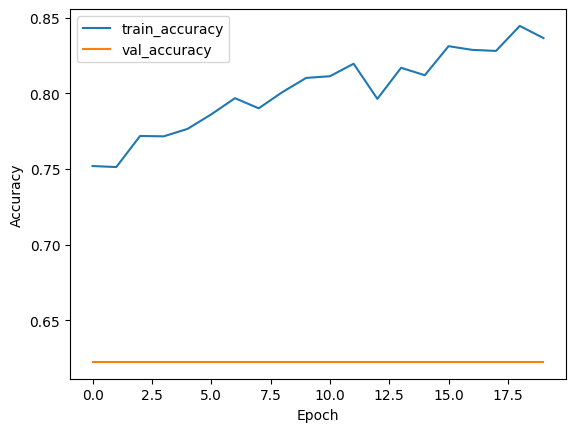

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(X_test, y_test))





plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Basic ConvNet with Pooling (WandB Simple)


In [ ]:
import random
import numpy as np
import tensorflow as tf
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


wandb.init(project="ConvNetChetada_EN", config={
    "learning_rate": random.uniform(0.001, 0.1),
    "dropout_rate": random.uniform(0.2, 0.5),
    "optimizer": "adam",
    "epochs": 100,
    "batch_size": 64,
})
config = wandb.config

model.compile(optimizer=config.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])




wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
]

model.fit(
    x=X_train,
    y=y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(X_test, y_test),
    callbacks=wandb_callbacks,
)


wandb.finish()


wandb: Currently logged in as: coralanaliticas. Use `wandb login --relogin` to force relogin


Epoch 1/100
 5/71 [=>............................] - ETA: 1s - loss: 0.6360 - accuracy: 0.6750

70/71 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6263

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


71/71 [==============================] - 8s 47ms/step - loss: 0.6598 - accuracy: 0.6263 - val_loss: 0.6612 - val_accuracy: 0.6148
Epoch 2/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.6257

wandb: Adding directory to artifact (./my_model_02)... Done. 0.0s


71/71 [==============================] - 3s 41ms/step - loss: 0.6535 - accuracy: 0.6265 - val_loss: 0.6589 - val_accuracy: 0.6152
Epoch 3/100
70/71 [============================>.] - ETA: 0s - loss: 0.6479 - accuracy: 0.6272

wandb: Adding directory to artifact (./my_model_03)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.6479 - accuracy: 0.6274 - val_loss: 0.6546 - val_accuracy: 0.6089
Epoch 4/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6474 - accuracy: 0.6296

wandb: Adding directory to artifact (./my_model_04)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.6469 - accuracy: 0.6301 - val_loss: 0.6600 - val_accuracy: 0.6179
Epoch 5/100
69/71 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.6232

wandb: Adding directory to artifact (./my_model_05)... Done. 0.0s


71/71 [==============================] - 3s 48ms/step - loss: 0.6438 - accuracy: 0.6236 - val_loss: 0.6738 - val_accuracy: 0.6107
Epoch 6/100
69/71 [============================>.] - ETA: 0s - loss: 0.6461 - accuracy: 0.6259

wandb: Adding directory to artifact (./my_model_06)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.6462 - accuracy: 0.6252 - val_loss: 0.6575 - val_accuracy: 0.6116
Epoch 7/100
70/71 [============================>.] - ETA: 0s - loss: 0.6410 - accuracy: 0.6183

wandb: Adding directory to artifact (./my_model_07)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.6409 - accuracy: 0.6185 - val_loss: 0.6533 - val_accuracy: 0.6120
Epoch 8/100
69/71 [============================>.] - ETA: 0s - loss: 0.6368 - accuracy: 0.6214

wandb: Adding directory to artifact (./my_model_08)... Done. 0.0s


71/71 [==============================] - 3s 43ms/step - loss: 0.6369 - accuracy: 0.6218 - val_loss: 0.6501 - val_accuracy: 0.6193
Epoch 9/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6374 - accuracy: 0.6310

wandb: Adding directory to artifact (./my_model_09)... Done. 0.0s


71/71 [==============================] - 3s 43ms/step - loss: 0.6363 - accuracy: 0.6330 - val_loss: 0.6435 - val_accuracy: 0.6166
Epoch 10/100
70/71 [============================>.] - ETA: 0s - loss: 0.6322 - accuracy: 0.6362

wandb: Adding directory to artifact (./my_model_10)... Done. 0.0s


71/71 [==============================] - 3s 43ms/step - loss: 0.6321 - accuracy: 0.6363 - val_loss: 0.6475 - val_accuracy: 0.6179
Epoch 11/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6262 - accuracy: 0.6319

wandb: Adding directory to artifact (./my_model_11)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.6280 - accuracy: 0.6312 - val_loss: 0.6456 - val_accuracy: 0.6234
Epoch 12/100
70/71 [============================>.] - ETA: 0s - loss: 0.6271 - accuracy: 0.6290

wandb: Adding directory to artifact (./my_model_12)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.6269 - accuracy: 0.6292 - val_loss: 0.6926 - val_accuracy: 0.6202
Epoch 13/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6399 - accuracy: 0.6266

wandb: Adding directory to artifact (./my_model_13)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.6389 - accuracy: 0.6272 - val_loss: 0.6534 - val_accuracy: 0.6234
Epoch 14/100
69/71 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.6329

wandb: Adding directory to artifact (./my_model_14)... Done. 0.0s


71/71 [==============================] - 3s 44ms/step - loss: 0.6228 - accuracy: 0.6336 - val_loss: 0.6419 - val_accuracy: 0.6197
Epoch 15/100
70/71 [============================>.] - ETA: 0s - loss: 0.6208 - accuracy: 0.6402

wandb: Adding directory to artifact (./my_model_15)... Done. 0.0s


71/71 [==============================] - 3s 40ms/step - loss: 0.6208 - accuracy: 0.6403 - val_loss: 0.6363 - val_accuracy: 0.6292
Epoch 16/100
70/71 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.6455

wandb: Adding directory to artifact (./my_model_16)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.6176 - accuracy: 0.6455 - val_loss: 0.6273 - val_accuracy: 0.6292
Epoch 17/100
70/71 [============================>.] - ETA: 0s - loss: 0.6113 - accuracy: 0.6496

wandb: Adding directory to artifact (./my_model_17)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.6114 - accuracy: 0.6495 - val_loss: 0.6305 - val_accuracy: 0.6320
Epoch 18/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6139 - accuracy: 0.6438

wandb: Adding directory to artifact (./my_model_18)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.6129 - accuracy: 0.6448 - val_loss: 0.6223 - val_accuracy: 0.6311
Epoch 19/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6033 - accuracy: 0.6546

wandb: Adding directory to artifact (./my_model_19)... Done. 0.0s


71/71 [==============================] - 3s 48ms/step - loss: 0.6015 - accuracy: 0.6568 - val_loss: 0.6262 - val_accuracy: 0.6306
Epoch 20/100
68/71 [===========================>..] - ETA: 0s - loss: 0.6058 - accuracy: 0.6579

wandb: Adding directory to artifact (./my_model_20)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.6056 - accuracy: 0.6591 - val_loss: 0.6148 - val_accuracy: 0.6360
Epoch 21/100
68/71 [===========================>..] - ETA: 0s - loss: 0.5962 - accuracy: 0.6636

wandb: Adding directory to artifact (./my_model_21)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.5959 - accuracy: 0.6638 - val_loss: 0.6220 - val_accuracy: 0.6324
Epoch 22/100
68/71 [===========================>..] - ETA: 0s - loss: 0.5954 - accuracy: 0.6675

wandb: Adding directory to artifact (./my_model_22)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.5962 - accuracy: 0.6656 - val_loss: 0.6156 - val_accuracy: 0.6464
Epoch 23/100
70/71 [============================>.] - ETA: 0s - loss: 0.5899 - accuracy: 0.6792

wandb: Adding directory to artifact (./my_model_23)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.5899 - accuracy: 0.6792 - val_loss: 0.6180 - val_accuracy: 0.6501
Epoch 24/100
69/71 [============================>.] - ETA: 0s - loss: 0.5835 - accuracy: 0.6932

wandb: Adding directory to artifact (./my_model_24)... Done. 0.0s


71/71 [==============================] - 3s 48ms/step - loss: 0.5837 - accuracy: 0.6930 - val_loss: 0.5980 - val_accuracy: 0.6754
Epoch 25/100
70/71 [============================>.] - ETA: 0s - loss: 0.5778 - accuracy: 0.6855

wandb: Adding directory to artifact (./my_model_25)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.5778 - accuracy: 0.6854 - val_loss: 0.5840 - val_accuracy: 0.6809
Epoch 26/100
68/71 [===========================>..] - ETA: 0s - loss: 0.5647 - accuracy: 0.6974

wandb: Adding directory to artifact (./my_model_26)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.5641 - accuracy: 0.6977 - val_loss: 0.5917 - val_accuracy: 0.6813
Epoch 27/100
70/71 [============================>.] - ETA: 0s - loss: 0.5622 - accuracy: 0.7103

wandb: Adding directory to artifact (./my_model_27)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.5622 - accuracy: 0.7102 - val_loss: 0.5723 - val_accuracy: 0.6981
Epoch 28/100
70/71 [============================>.] - ETA: 0s - loss: 0.5446 - accuracy: 0.7214

wandb: Adding directory to artifact (./my_model_28)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.5445 - accuracy: 0.7216 - val_loss: 0.5819 - val_accuracy: 0.6858
Epoch 29/100
70/71 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.7228

wandb: Adding directory to artifact (./my_model_29)... Done. 0.0s


71/71 [==============================] - 3s 41ms/step - loss: 0.5420 - accuracy: 0.7227 - val_loss: 0.6029 - val_accuracy: 0.6677
Epoch 30/100
70/71 [============================>.] - ETA: 0s - loss: 0.5360 - accuracy: 0.7279

wandb: Adding directory to artifact (./my_model_30)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.5359 - accuracy: 0.7280 - val_loss: 0.5571 - val_accuracy: 0.7026
Epoch 31/100
68/71 [===========================>..] - ETA: 0s - loss: 0.5220 - accuracy: 0.7413

wandb: Adding directory to artifact (./my_model_31)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.5205 - accuracy: 0.7407 - val_loss: 0.5408 - val_accuracy: 0.7153
Epoch 32/100
70/71 [============================>.] - ETA: 0s - loss: 0.5135 - accuracy: 0.7429

wandb: Adding directory to artifact (./my_model_32)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.5135 - accuracy: 0.7430 - val_loss: 0.6032 - val_accuracy: 0.6600
Epoch 33/100
71/71 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.7334

wandb: Adding directory to artifact (./my_model_33)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.5326 - accuracy: 0.7334 - val_loss: 0.5368 - val_accuracy: 0.7211
Epoch 34/100
71/71 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.7425

wandb: Adding directory to artifact (./my_model_34)... Done. 0.0s


71/71 [==============================] - 3s 41ms/step - loss: 0.5132 - accuracy: 0.7425 - val_loss: 0.5274 - val_accuracy: 0.7379
Epoch 35/100
68/71 [===========================>..] - ETA: 0s - loss: 0.5031 - accuracy: 0.7500

wandb: Adding directory to artifact (./my_model_35)... Done. 0.0s


71/71 [==============================] - 3s 43ms/step - loss: 0.5041 - accuracy: 0.7479 - val_loss: 0.5188 - val_accuracy: 0.7379
Epoch 36/100
70/71 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.7741

wandb: Adding directory to artifact (./my_model_36)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.4840 - accuracy: 0.7738 - val_loss: 0.5503 - val_accuracy: 0.7094
Epoch 37/100
69/71 [============================>.] - ETA: 0s - loss: 0.5042 - accuracy: 0.7475

wandb: Adding directory to artifact (./my_model_37)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.5044 - accuracy: 0.7481 - val_loss: 0.5112 - val_accuracy: 0.7546
Epoch 38/100
69/71 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.7690

wandb: Adding directory to artifact (./my_model_38)... Done. 0.0s


71/71 [==============================] - 3s 46ms/step - loss: 0.4842 - accuracy: 0.7695 - val_loss: 0.5392 - val_accuracy: 0.7270
Epoch 39/100
70/71 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.7779

wandb: Adding directory to artifact (./my_model_39)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.4656 - accuracy: 0.7778 - val_loss: 0.4957 - val_accuracy: 0.7560
Epoch 40/100
68/71 [===========================>..] - ETA: 0s - loss: 0.4938 - accuracy: 0.7557

wandb: Adding directory to artifact (./my_model_40)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.4944 - accuracy: 0.7548 - val_loss: 0.5065 - val_accuracy: 0.7420
Epoch 41/100
70/71 [============================>.] - ETA: 0s - loss: 0.4502 - accuracy: 0.7882

wandb: Adding directory to artifact (./my_model_41)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.4502 - accuracy: 0.7883 - val_loss: 0.5138 - val_accuracy: 0.7302
Epoch 42/100
70/71 [============================>.] - ETA: 0s - loss: 0.4491 - accuracy: 0.7877

wandb: Adding directory to artifact (./my_model_42)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.4489 - accuracy: 0.7878 - val_loss: 0.5091 - val_accuracy: 0.7483
Epoch 43/100
70/71 [============================>.] - ETA: 0s - loss: 0.4391 - accuracy: 0.7955

wandb: Adding directory to artifact (./my_model_43)... Done. 0.0s


71/71 [==============================] - 3s 47ms/step - loss: 0.4389 - accuracy: 0.7956 - val_loss: 0.4754 - val_accuracy: 0.7678
Epoch 44/100
69/71 [============================>.] - ETA: 0s - loss: 0.4345 - accuracy: 0.8007

wandb: Adding directory to artifact (./my_model_44)... Done. 0.0s


71/71 [==============================] - 3s 47ms/step - loss: 0.4342 - accuracy: 0.8012 - val_loss: 0.5007 - val_accuracy: 0.7560
Epoch 45/100
69/71 [============================>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.7928

wandb: Adding directory to artifact (./my_model_45)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.4467 - accuracy: 0.7918 - val_loss: 0.5413 - val_accuracy: 0.7465
Epoch 46/100
69/71 [============================>.] - ETA: 0s - loss: 0.4542 - accuracy: 0.7860

wandb: Adding directory to artifact (./my_model_46)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.4545 - accuracy: 0.7858 - val_loss: 0.5528 - val_accuracy: 0.7112
Epoch 47/100
68/71 [===========================>..] - ETA: 0s - loss: 0.4384 - accuracy: 0.7971

wandb: Adding directory to artifact (./my_model_47)... Done. 0.0s


71/71 [==============================] - 3s 44ms/step - loss: 0.4389 - accuracy: 0.7956 - val_loss: 0.4954 - val_accuracy: 0.7660
Epoch 48/100
71/71 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8104

wandb: Adding directory to artifact (./my_model_48)... Done. 0.0s


71/71 [==============================] - 3s 44ms/step - loss: 0.4201 - accuracy: 0.8104 - val_loss: 0.4627 - val_accuracy: 0.7804
Epoch 49/100
70/71 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8103

wandb: Adding directory to artifact (./my_model_49)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.4121 - accuracy: 0.8104 - val_loss: 0.6350 - val_accuracy: 0.6587
Epoch 50/100
70/71 [============================>.] - ETA: 0s - loss: 0.4386 - accuracy: 0.8007

wandb: Adding directory to artifact (./my_model_50)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.4384 - accuracy: 0.8008 - val_loss: 0.4615 - val_accuracy: 0.7773
Epoch 51/100
69/71 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8191

wandb: Adding directory to artifact (./my_model_51)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.4020 - accuracy: 0.8191 - val_loss: 0.4821 - val_accuracy: 0.7700
Epoch 52/100
70/71 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.8263

wandb: Adding directory to artifact (./my_model_52)... Done. 0.0s


71/71 [==============================] - 3s 43ms/step - loss: 0.3951 - accuracy: 0.8262 - val_loss: 0.4714 - val_accuracy: 0.7795
Epoch 53/100
70/71 [============================>.] - ETA: 0s - loss: 0.3931 - accuracy: 0.8217

wandb: Adding directory to artifact (./my_model_53)... Done. 0.0s


71/71 [==============================] - 4s 51ms/step - loss: 0.3931 - accuracy: 0.8215 - val_loss: 0.6297 - val_accuracy: 0.6682
Epoch 54/100
68/71 [===========================>..] - ETA: 0s - loss: 0.4118 - accuracy: 0.8185

wandb: Adding directory to artifact (./my_model_54)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.4107 - accuracy: 0.8184 - val_loss: 0.4587 - val_accuracy: 0.7823
Epoch 55/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3750 - accuracy: 0.8355

wandb: Adding directory to artifact (./my_model_55)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3761 - accuracy: 0.8356 - val_loss: 0.4567 - val_accuracy: 0.7800
Epoch 56/100
70/71 [============================>.] - ETA: 0s - loss: 0.3735 - accuracy: 0.8330

wandb: Adding directory to artifact (./my_model_56)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.3734 - accuracy: 0.8331 - val_loss: 0.4477 - val_accuracy: 0.7913
Epoch 57/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3600 - accuracy: 0.8392

wandb: Adding directory to artifact (./my_model_57)... Done. 0.0s


71/71 [==============================] - 3s 47ms/step - loss: 0.3638 - accuracy: 0.8365 - val_loss: 0.4505 - val_accuracy: 0.7890
Epoch 58/100
69/71 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8356

wandb: Adding directory to artifact (./my_model_58)... Done. 0.0s


71/71 [==============================] - 3s 41ms/step - loss: 0.3670 - accuracy: 0.8349 - val_loss: 0.5392 - val_accuracy: 0.7641
Epoch 59/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3769 - accuracy: 0.8323

wandb: Adding directory to artifact (./my_model_59)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.3768 - accuracy: 0.8324 - val_loss: 0.4905 - val_accuracy: 0.7782
Epoch 60/100
70/71 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8433

wandb: Adding directory to artifact (./my_model_60)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3523 - accuracy: 0.8434 - val_loss: 0.4459 - val_accuracy: 0.7868
Epoch 61/100
71/71 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8496

wandb: Adding directory to artifact (./my_model_61)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3492 - accuracy: 0.8496 - val_loss: 0.4538 - val_accuracy: 0.7795
Epoch 62/100
69/71 [============================>.] - ETA: 0s - loss: 0.3395 - accuracy: 0.8542

wandb: Adding directory to artifact (./my_model_62)... Done. 0.0s


71/71 [==============================] - 4s 56ms/step - loss: 0.3374 - accuracy: 0.8556 - val_loss: 0.4524 - val_accuracy: 0.7895
Epoch 63/100
69/71 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8521

wandb: Adding directory to artifact (./my_model_63)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.3436 - accuracy: 0.8516 - val_loss: 0.4519 - val_accuracy: 0.7813
Epoch 64/100
69/71 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8447

wandb: Adding directory to artifact (./my_model_64)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3555 - accuracy: 0.8447 - val_loss: 0.4750 - val_accuracy: 0.7687
Epoch 65/100
69/71 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8512

wandb: Adding directory to artifact (./my_model_65)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.3395 - accuracy: 0.8519 - val_loss: 0.5402 - val_accuracy: 0.7696
Epoch 66/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3831 - accuracy: 0.8251

wandb: Adding directory to artifact (./my_model_66)... Done. 0.0s


71/71 [==============================] - 3s 41ms/step - loss: 0.3817 - accuracy: 0.8269 - val_loss: 0.4328 - val_accuracy: 0.7986
Epoch 67/100
69/71 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8671

wandb: Adding directory to artifact (./my_model_67)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.3194 - accuracy: 0.8670 - val_loss: 0.4691 - val_accuracy: 0.7881
Epoch 68/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3222 - accuracy: 0.8624

wandb: Adding directory to artifact (./my_model_68)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.3220 - accuracy: 0.8630 - val_loss: 0.4406 - val_accuracy: 0.8126
Epoch 69/100
69/71 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8736

wandb: Adding directory to artifact (./my_model_69)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.3143 - accuracy: 0.8730 - val_loss: 0.4267 - val_accuracy: 0.8022
Epoch 70/100
71/71 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8681

wandb: Adding directory to artifact (./my_model_70)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.3144 - accuracy: 0.8681 - val_loss: 0.4495 - val_accuracy: 0.8053
Epoch 71/100
68/71 [===========================>..] - ETA: 0s - loss: 0.2991 - accuracy: 0.8759

wandb: Adding directory to artifact (./my_model_71)... Done. 0.0s


71/71 [==============================] - 4s 52ms/step - loss: 0.2986 - accuracy: 0.8764 - val_loss: 0.4346 - val_accuracy: 0.8008
Epoch 72/100
70/71 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.8763

wandb: Adding directory to artifact (./my_model_72)... Done. 0.0s


71/71 [==============================] - 3s 41ms/step - loss: 0.2928 - accuracy: 0.8764 - val_loss: 0.4353 - val_accuracy: 0.8099
Epoch 73/100
70/71 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8763

wandb: Adding directory to artifact (./my_model_73)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.2916 - accuracy: 0.8764 - val_loss: 0.4209 - val_accuracy: 0.8135
Epoch 74/100
68/71 [===========================>..] - ETA: 0s - loss: 0.2903 - accuracy: 0.8805

wandb: Adding directory to artifact (./my_model_74)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.2897 - accuracy: 0.8811 - val_loss: 0.4325 - val_accuracy: 0.8103
Epoch 75/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3012 - accuracy: 0.8791

wandb: Adding directory to artifact (./my_model_75)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3012 - accuracy: 0.8791 - val_loss: 0.5073 - val_accuracy: 0.7510
Epoch 76/100
69/71 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8668

wandb: Adding directory to artifact (./my_model_76)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.3095 - accuracy: 0.8677 - val_loss: 0.4505 - val_accuracy: 0.7895
Epoch 77/100
69/71 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8784

wandb: Adding directory to artifact (./my_model_77)... Done. 0.0s


71/71 [==============================] - 3s 42ms/step - loss: 0.2858 - accuracy: 0.8775 - val_loss: 0.4742 - val_accuracy: 0.7655
Epoch 78/100
70/71 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8813

wandb: Adding directory to artifact (./my_model_78)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.2828 - accuracy: 0.8811 - val_loss: 0.5304 - val_accuracy: 0.7451
Epoch 79/100
70/71 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8687

wandb: Adding directory to artifact (./my_model_79)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.3093 - accuracy: 0.8688 - val_loss: 0.4124 - val_accuracy: 0.8117
Epoch 80/100
70/71 [============================>.] - ETA: 0s - loss: 0.2601 - accuracy: 0.8929

wandb: Adding directory to artifact (./my_model_80)... Done. 0.0s


71/71 [==============================] - 3s 45ms/step - loss: 0.2600 - accuracy: 0.8929 - val_loss: 0.4092 - val_accuracy: 0.8239
Epoch 81/100
70/71 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9009

wandb: Adding directory to artifact (./my_model_81)... Done. 0.0s


71/71 [==============================] - 6s 79ms/step - loss: 0.2538 - accuracy: 0.9009 - val_loss: 0.3999 - val_accuracy: 0.8339
Epoch 82/100
69/71 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.9051

wandb: Adding directory to artifact (./my_model_82)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.2432 - accuracy: 0.9043 - val_loss: 0.7618 - val_accuracy: 0.6700
Epoch 83/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3607 - accuracy: 0.8467

wandb: Adding directory to artifact (./my_model_83)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3586 - accuracy: 0.8474 - val_loss: 0.5396 - val_accuracy: 0.7478
Epoch 84/100
68/71 [===========================>..] - ETA: 0s - loss: 0.3026 - accuracy: 0.8683

wandb: Adding directory to artifact (./my_model_84)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.3004 - accuracy: 0.8695 - val_loss: 0.4786 - val_accuracy: 0.7759
Epoch 85/100
69/71 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8877

wandb: Adding directory to artifact (./my_model_85)... Done. 0.0s


71/71 [==============================] - 3s 47ms/step - loss: 0.2685 - accuracy: 0.8878 - val_loss: 0.4627 - val_accuracy: 0.8144
Epoch 86/100
68/71 [===========================>..] - ETA: 0s - loss: 0.2357 - accuracy: 0.9085

wandb: Adding directory to artifact (./my_model_86)... Done. 0.0s


71/71 [==============================] - 3s 40ms/step - loss: 0.2354 - accuracy: 0.9087 - val_loss: 0.4095 - val_accuracy: 0.8302
Epoch 87/100
70/71 [============================>.] - ETA: 0s - loss: 0.2266 - accuracy: 0.9156

wandb: Adding directory to artifact (./my_model_87)... Done. 0.0s


71/71 [==============================] - 3s 37ms/step - loss: 0.2265 - accuracy: 0.9157 - val_loss: 0.4973 - val_accuracy: 0.8090
Epoch 88/100
69/71 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.9103

wandb: Adding directory to artifact (./my_model_88)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.2330 - accuracy: 0.9105 - val_loss: 0.4283 - val_accuracy: 0.8271
Epoch 89/100
71/71 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.8971

wandb: Adding directory to artifact (./my_model_89)... Done. 0.0s


71/71 [==============================] - 3s 47ms/step - loss: 0.2472 - accuracy: 0.8971 - val_loss: 0.4103 - val_accuracy: 0.8302
Epoch 90/100
69/71 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9119

wandb: Adding directory to artifact (./my_model_90)... Done. 0.0s


71/71 [==============================] - 3s 47ms/step - loss: 0.2240 - accuracy: 0.9121 - val_loss: 0.4572 - val_accuracy: 0.7995
Epoch 91/100
68/71 [===========================>..] - ETA: 0s - loss: 0.2120 - accuracy: 0.9173

wandb: Adding directory to artifact (./my_model_91)... Done. 0.0s


71/71 [==============================] - 4s 61ms/step - loss: 0.2114 - accuracy: 0.9168 - val_loss: 0.5065 - val_accuracy: 0.8112
Epoch 92/100
70/71 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9174

wandb: Adding directory to artifact (./my_model_92)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.2163 - accuracy: 0.9174 - val_loss: 0.4339 - val_accuracy: 0.8239
Epoch 93/100
70/71 [============================>.] - ETA: 0s - loss: 0.2460 - accuracy: 0.9011

wandb: Adding directory to artifact (./my_model_93)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.2460 - accuracy: 0.9012 - val_loss: 0.4694 - val_accuracy: 0.7800
Epoch 94/100
70/71 [============================>.] - ETA: 0s - loss: 0.2241 - accuracy: 0.9107

wandb: Adding directory to artifact (./my_model_94)... Done. 0.0s


71/71 [==============================] - 3s 49ms/step - loss: 0.2240 - accuracy: 0.9108 - val_loss: 0.6419 - val_accuracy: 0.7800
Epoch 95/100
69/71 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9178

wandb: Adding directory to artifact (./my_model_95)... Done. 0.0s


71/71 [==============================] - 3s 39ms/step - loss: 0.2142 - accuracy: 0.9170 - val_loss: 0.5224 - val_accuracy: 0.8144
Epoch 96/100
69/71 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9214

wandb: Adding directory to artifact (./my_model_96)... Done. 0.0s


71/71 [==============================] - 2s 35ms/step - loss: 0.2022 - accuracy: 0.9217 - val_loss: 0.4168 - val_accuracy: 0.8271
Epoch 97/100
70/71 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9187

wandb: Adding directory to artifact (./my_model_97)... Done. 0.0s


71/71 [==============================] - 3s 36ms/step - loss: 0.2053 - accuracy: 0.9188 - val_loss: 0.4959 - val_accuracy: 0.7841
Epoch 98/100
69/71 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9248

wandb: Adding directory to artifact (./my_model_98)... Done. 0.0s


71/71 [==============================] - 3s 49ms/step - loss: 0.1956 - accuracy: 0.9239 - val_loss: 0.4689 - val_accuracy: 0.7804
Epoch 99/100
71/71 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.8882

wandb: Adding directory to artifact (./my_model_99)... Done. 0.0s


71/71 [==============================] - 3s 44ms/step - loss: 0.2614 - accuracy: 0.8882 - val_loss: 0.4610 - val_accuracy: 0.8257
Epoch 100/100
68/71 [===========================>..] - ETA: 0s - loss: 0.2108 - accuracy: 0.9223

wandb: Adding directory to artifact (./my_model_100)... Done. 0.0s


71/71 [==============================] - 3s 38ms/step - loss: 0.2109 - accuracy: 0.9228 - val_loss: 0.5899 - val_accuracy: 0.7429


epoch/accuracy,▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇█▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▃▂▂▁▂▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▂▂▂▂▃▃▄▅▄▆▅▆▄▃▆▆▇▆▆▆▇▇▇▇▆▇▃▆▇██▆▇▅
epoch/val_loss,▆▆▆▆▆▆▅▅▅▅▅▄▄▃▄▃▃▃▄▅▂▂▂▃▂▂▂▁▁▁▂▁█▂▃▁▁▆▃▅
epoch/accuracy,0.9228
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.21094
epoch/val_accuracy,0.74287


#### Basic ConvNet with Pooling (WandB Random Search)

In [ ]:
import random
import numpy as np
import tensorflow as tf
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


sweep_config = {
    'method': 'random'
    }
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    }

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)




{'method': 'random',
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ConvNetChetadaAgent_EN")

Create sweep with ID: 9avss3wy
Sweep URL: https://wandb.ai/coralanaliticas/ConvNetChetadaAgent_EN/sweeps/9avss3wy


In [ ]:
from wandb.keras import WandbCallback

def train():

    for _ in range(10):

        config_defaults = {
            'optimizer': random.choice(sweep_config['parameters']['optimizer']['values']),
            'dropout': random.choice(sweep_config['parameters']['dropout']['values']),
            'learning_rate': random.uniform(sweep_config['parameters']['learning_rate']['min'],
                                            sweep_config['parameters']['learning_rate']['max']),
            'batch_size': int(random.randint(sweep_config['parameters']['batch_size']['min'],
                                              sweep_config['parameters']['batch_size']['max']))
        }


        wandb.init(config=config_defaults)

        model.compile(optimizer=config_defaults['optimizer'],
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])


        model.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=config_defaults['batch_size'],
                  callbacks=[WandbCallback()])


wandb.agent(sweep_id, function=train)


wandb: Agent Starting Run: yv1ja6ow with config:
wandb: 	batch_size: 160
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.06124207758697408
wandb: 	optimizer: sgd


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
 5/41 [==>...........................] - ETA: 0s - loss: 0.6832 - accuracy: 0.6304

41/41 [==============================] - 4s 27ms/step - loss: 0.6721 - accuracy: 0.6263
Epoch 2/50
41/41 [==============================] - 1s 26ms/step - loss: 0.6606 - accuracy: 0.6263
Epoch 3/50
41/41 [==============================] - 1s 26ms/step - loss: 0.6581 - accuracy: 0.6263
Epoch 4/50
41/41 [==============================] - 1s 27ms/step - loss: 0.6572 - accuracy: 0.6263
Epoch 5/50
41/41 [==============================] - 1s 27ms/step - loss: 0.6571 - accuracy: 0.6263
Epoch 6/50
41/41 [==============================] - 1s 29ms/step - loss: 0.6568 - accuracy: 0.6263
Epoch 7/50
41/41 [==============================] - 1s 28ms/step - loss: 0.6565 - accuracy: 0.6263
Epoch 8/50
41/41 [==============================] - 1s 29ms/step - loss: 0.6563 - accuracy: 0.6263
Epoch 9/50
41/41 [==============================] - 1s 27ms/step - loss: 0.6562 - accuracy: 0.6263
Epoch 10/50
41/41 [==============================] - 1s 27ms/step - loss: 0.6559 - accuracy: 0.6263
Epoch 11/50
41/41 [=

wandb: Ctrl + C detected. Stopping sweep.


#### U-net

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense


def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dense = Dense(2, activation='softmax')(flatten)


    model = Model(inputs=inputs, outputs=dense)
    return model

model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

Epoch 1/50
71/71 [==============================] - 43s 253ms/step - loss: 0.7644 - accuracy: 0.6423 - val_loss: 0.6500 - val_accuracy: 0.6813
Epoch 2/50
71/71 [==============================] - 13s 178ms/step - loss: 0.6087 - accuracy: 0.6850 - val_loss: 0.6077 - val_accuracy: 0.6636
Epoch 3/50
71/71 [==============================] - 13s 178ms/step - loss: 0.5233 - accuracy: 0.7358 - val_loss: 0.5332 - val_accuracy: 0.7356
Epoch 4/50
71/71 [==============================] - 12s 176ms/step - loss: 0.4699 - accuracy: 0.7802 - val_loss: 0.5035 - val_accuracy: 0.7583
Epoch 5/50
71/71 [==============================] - 13s 186ms/step - loss: 0.4299 - accuracy: 0.8037 - val_loss: 0.5078 - val_accuracy: 0.7533
Epoch 6/50
71/71 [==============================] - 12s 173ms/step - loss: 0.3500 - accuracy: 0.8420 - val_loss: 0.4334 - val_accuracy: 0.8022
Epoch 7/50
71/71 [==============================] - 13s 185ms/step - loss: 0.2300 - accuracy: 0.9110 - val_loss: 0.5220 - val_accuracy: 0.7773

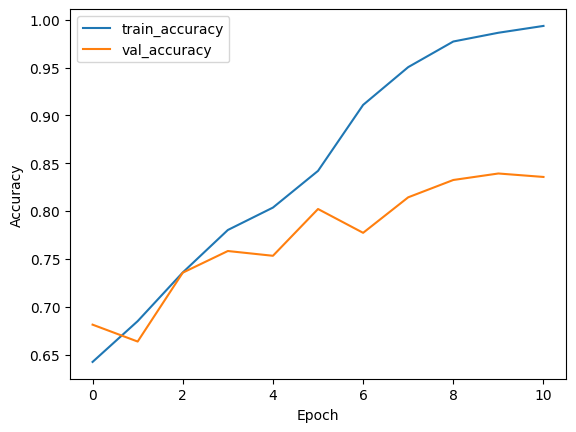

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


  U-Net 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers


def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dense = Dense(2, activation='softmax')(flatten)


    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
71/71 [==============================] - 23s 224ms/step - loss: 6.5837 - accuracy: 0.6316 - val_loss: 55.0113 - val_accuracy: 0.3852
Epoch 2/50
71/71 [==============================] - 15s 214ms/step - loss: 3.2225 - accuracy: 0.7158 - val_loss: 2.6563 - val_accuracy: 0.4771
Epoch 3/50
71/71 [==============================] - 15s 207ms/step - loss: 2.5162 - accuracy: 0.7793 - val_loss: 4.4747 - val_accuracy: 0.4215
Epoch 4/50
71/71 [==============================] - 14s 197ms/step - loss: 0.9788 - accuracy: 0.8831 - val_loss: 1.8299 - val_accuracy: 0.5283
Epoch 5/50
71/71 [==============================] - 14s 204ms/step - loss: 0.4828 - accuracy: 0.9261 - val_loss: 2.8602 - val_accuracy: 0.5138
Epoch 6/50
71/71 [==============================] - 14s 203ms/step - loss: 0.2863 - accuracy: 0.9491 - val_loss: 1.4227 - val_accuracy: 0.6904
Epoch 7/50
71/71 [==============================] - 14s 203ms/step - loss: 0.1477 - accuracy: 0.9670 - val_loss: 1.2894 - val_accuracy: 0.771

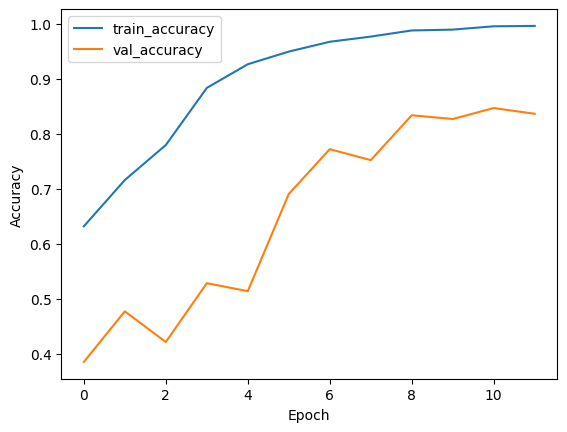

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


U-Net 3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers


def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dropout = Dropout(0.5)(flatten)
    dense = Dense(2, activation='softmax')(dropout)

    # Modelo final
    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
71/71 [==============================] - 26s 235ms/step - loss: 6.2323 - accuracy: 0.6316 - val_loss: 1.0182 - val_accuracy: 0.6564
Epoch 2/50
71/71 [==============================] - 14s 201ms/step - loss: 3.6334 - accuracy: 0.7178 - val_loss: 1.8753 - val_accuracy: 0.5346
Epoch 3/50
71/71 [==============================] - 15s 208ms/step - loss: 5.3468 - accuracy: 0.7218 - val_loss: 8.4425 - val_accuracy: 0.5315
Epoch 4/50
71/71 [==============================] - 14s 196ms/step - loss: 2.7753 - accuracy: 0.8110 - val_loss: 3.6099 - val_accuracy: 0.6781
Epoch 5/50
71/71 [==============================] - 14s 196ms/step - loss: 1.9059 - accuracy: 0.8534 - val_loss: 2.2753 - val_accuracy: 0.7230
Epoch 6/50
71/71 [==============================] - 15s 206ms/step - loss: 2.7991 - accuracy: 0.8291 - val_loss: 3.3599 - val_accuracy: 0.7565


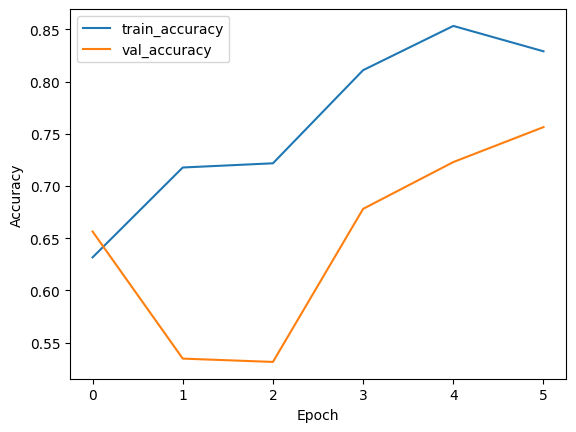

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

UNet-4

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dropout = Dropout(0.6)(flatten)
    dense = Dense(2, activation='softmax')(dropout)

    # Modelo final
    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
71/71 [==============================] - 24s 242ms/step - loss: 4.6052 - accuracy: 0.6243 - val_loss: 24.2311 - val_accuracy: 0.6152
Epoch 2/50
71/71 [==============================] - 17s 236ms/step - loss: 5.4329 - accuracy: 0.6678 - val_loss: 60.7064 - val_accuracy: 0.6152
Epoch 3/50
71/71 [==============================] - 17s 235ms/step - loss: 4.3167 - accuracy: 0.7104 - val_loss: 21.7339 - val_accuracy: 0.6043
Epoch 4/50
71/71 [==============================] - 17s 233ms/step - loss: 2.9455 - accuracy: 0.7726 - val_loss: 6.0560 - val_accuracy: 0.5921
Epoch 5/50
71/71 [==============================] - 17s 242ms/step - loss: 2.0823 - accuracy: 0.8139 - val_loss: 2.6070 - val_accuracy: 0.5745
Epoch 6/50
71/71 [==============================] - 17s 233ms/step - loss: 1.7509 - accuracy: 0.8394 - val_loss: 2.0151 - val_accuracy: 0.7334
Epoch 7/50
71/71 [==============================] - 17s 233ms/step - loss: 1.4867 - accuracy: 0.8670 - val_loss: 4.7548 - val_accuracy: 0.6

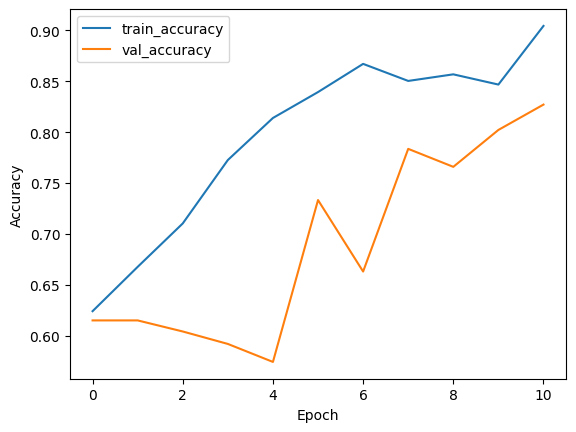

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Entrenamiento Dataset Aumentado

#### Dataset

In [ ]:
import h5py
from keras.utils import to_categorical

ruta_archivo = '/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Dataset/datos_aumentados_orig.h5'

with h5py.File(ruta_archivo, 'r') as f:

    X_train = f['X_train'][:]
    y_train = f['y_train'][:]


print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)




Forma de X_train: (44820, 64, 64, 1)
Forma de y_train: (44820, 2)


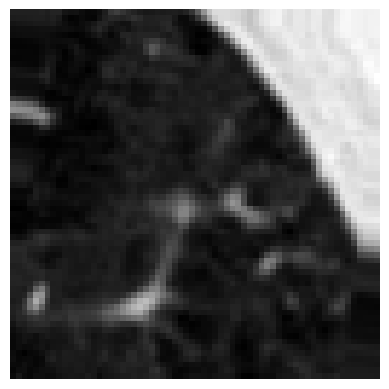

In [ ]:
index = 1122
image = X_train[index]


plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

#### Basic ConvNet with Pooling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                   

Epoch 1/50
701/701 [==============================] - 17s 16ms/step - loss: 0.8137 - accuracy: 0.6511 - val_loss: 0.5831 - val_accuracy: 0.6809
Epoch 2/50
701/701 [==============================] - 11s 15ms/step - loss: 0.5784 - accuracy: 0.6968 - val_loss: 0.5552 - val_accuracy: 0.7094
Epoch 3/50
701/701 [==============================] - 11s 15ms/step - loss: 0.5448 - accuracy: 0.7217 - val_loss: 0.5138 - val_accuracy: 0.7488
Epoch 4/50
701/701 [==============================] - 11s 15ms/step - loss: 0.5172 - accuracy: 0.7406 - val_loss: 0.4820 - val_accuracy: 0.7718
Epoch 5/50
701/701 [==============================] - 11s 16ms/step - loss: 0.4961 - accuracy: 0.7567 - val_loss: 0.5267 - val_accuracy: 0.7433
Epoch 6/50
701/701 [==============================] - 11s 15ms/step - loss: 0.4689 - accuracy: 0.7744 - val_loss: 0.5388 - val_accuracy: 0.7130
Epoch 7/50
701/701 [==============================] - 11s 15ms/step - loss: 0.4458 - accuracy: 0.7889 - val_loss: 0.4592 - val_accuracy:

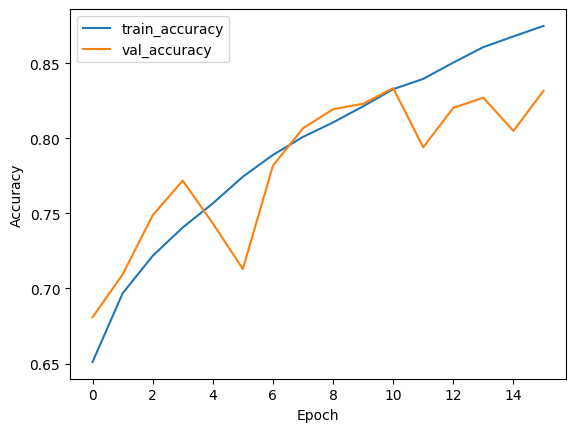

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])





plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Basic ConvNet with Pooling (WandB Simple)


In [ ]:
import random
import numpy as np
import tensorflow as tf
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


wandb.init(project="ConvNetChetada_DA", config={
    "learning_rate": random.uniform(0.001, 0.1),
    "dropout_rate": random.uniform(0.2, 0.5),
    "optimizer": "adam",
    "epochs": 50,
    "batch_size": 64,
})
config = wandb.config

model.compile(optimizer=config.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



# Add Wandb callbacks to the model fitting
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
]

model.fit(
    x=X_train,
    y=y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(X_test, y_test),
    callbacks=wandb_callbacks,
)


wandb.finish()


Epoch 1/50
  5/701 [..............................] - ETA: 18s - loss: 59.6970 - accuracy: 0.4313

701/701 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.6388

wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


701/701 [==============================] - 15s 19ms/step - loss: 1.1672 - accuracy: 0.6388 - val_loss: 0.5946 - val_accuracy: 0.6976
Epoch 2/50
700/701 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.6909

wandb: Adding directory to artifact (./my_model_02)... Done. 0.0s


701/701 [==============================] - 15s 21ms/step - loss: 0.5876 - accuracy: 0.6910 - val_loss: 0.5649 - val_accuracy: 0.7021
Epoch 3/50
698/701 [============================>.] - ETA: 0s - loss: 0.5566 - accuracy: 0.7159

wandb: Adding directory to artifact (./my_model_03)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.5567 - accuracy: 0.7159 - val_loss: 0.5451 - val_accuracy: 0.7220
Epoch 4/50
698/701 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7346

wandb: Adding directory to artifact (./my_model_04)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.5305 - accuracy: 0.7348 - val_loss: 0.5260 - val_accuracy: 0.7411
Epoch 5/50
699/701 [============================>.] - ETA: 0s - loss: 0.5047 - accuracy: 0.7549

wandb: Adding directory to artifact (./my_model_05)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.5048 - accuracy: 0.7549 - val_loss: 0.4794 - val_accuracy: 0.7759
Epoch 6/50
700/701 [============================>.] - ETA: 0s - loss: 0.4809 - accuracy: 0.7704

wandb: Adding directory to artifact (./my_model_06)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.4810 - accuracy: 0.7703 - val_loss: 0.4566 - val_accuracy: 0.7895
Epoch 7/50
698/701 [============================>.] - ETA: 0s - loss: 0.4652 - accuracy: 0.7776

wandb: Adding directory to artifact (./my_model_07)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.4651 - accuracy: 0.7777 - val_loss: 0.4523 - val_accuracy: 0.7981
Epoch 8/50
698/701 [============================>.] - ETA: 0s - loss: 0.4407 - accuracy: 0.7946

wandb: Adding directory to artifact (./my_model_08)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.4408 - accuracy: 0.7945 - val_loss: 0.4662 - val_accuracy: 0.7967
Epoch 9/50
699/701 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8019

wandb: Adding directory to artifact (./my_model_09)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.4259 - accuracy: 0.8020 - val_loss: 0.4141 - val_accuracy: 0.8108
Epoch 10/50
700/701 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.8138

wandb: Adding directory to artifact (./my_model_10)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.4056 - accuracy: 0.8138 - val_loss: 0.4394 - val_accuracy: 0.8130
Epoch 11/50
698/701 [============================>.] - ETA: 0s - loss: 0.3920 - accuracy: 0.8217

wandb: Adding directory to artifact (./my_model_11)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.3925 - accuracy: 0.8213 - val_loss: 0.4447 - val_accuracy: 0.8013
Epoch 12/50
699/701 [============================>.] - ETA: 0s - loss: 0.3780 - accuracy: 0.8288

wandb: Adding directory to artifact (./my_model_12)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.3781 - accuracy: 0.8287 - val_loss: 0.4089 - val_accuracy: 0.8407
Epoch 13/50
701/701 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.8405

wandb: Adding directory to artifact (./my_model_13)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.3600 - accuracy: 0.8405 - val_loss: 0.4887 - val_accuracy: 0.8185
Epoch 14/50
701/701 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8499

wandb: Adding directory to artifact (./my_model_14)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.3413 - accuracy: 0.8499 - val_loss: 0.4450 - val_accuracy: 0.8212
Epoch 15/50
701/701 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8587

wandb: Adding directory to artifact (./my_model_15)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.3241 - accuracy: 0.8587 - val_loss: 0.4913 - val_accuracy: 0.8126
Epoch 16/50
698/701 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8664

wandb: Adding directory to artifact (./my_model_16)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.3085 - accuracy: 0.8664 - val_loss: 0.4208 - val_accuracy: 0.8298
Epoch 17/50
700/701 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8734

wandb: Adding directory to artifact (./my_model_17)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.2912 - accuracy: 0.8734 - val_loss: 0.4536 - val_accuracy: 0.8352
Epoch 18/50
701/701 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8826

wandb: Adding directory to artifact (./my_model_18)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.2730 - accuracy: 0.8826 - val_loss: 0.4808 - val_accuracy: 0.8248
Epoch 19/50
701/701 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.8890

wandb: Adding directory to artifact (./my_model_19)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.2597 - accuracy: 0.8890 - val_loss: 0.4758 - val_accuracy: 0.8185
Epoch 20/50
701/701 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.8967

wandb: Adding directory to artifact (./my_model_20)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.2428 - accuracy: 0.8967 - val_loss: 0.5955 - val_accuracy: 0.7850
Epoch 21/50
699/701 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.8976

wandb: Adding directory to artifact (./my_model_21)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.2379 - accuracy: 0.8976 - val_loss: 0.5547 - val_accuracy: 0.8085
Epoch 22/50
699/701 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9085

wandb: Adding directory to artifact (./my_model_22)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.2152 - accuracy: 0.9085 - val_loss: 0.4846 - val_accuracy: 0.8325
Epoch 23/50
699/701 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9154

wandb: Adding directory to artifact (./my_model_23)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.2033 - accuracy: 0.9153 - val_loss: 0.5633 - val_accuracy: 0.8153
Epoch 24/50
699/701 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9182

wandb: Adding directory to artifact (./my_model_24)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1928 - accuracy: 0.9182 - val_loss: 0.5796 - val_accuracy: 0.8348
Epoch 25/50
699/701 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9212

wandb: Adding directory to artifact (./my_model_25)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.1887 - accuracy: 0.9213 - val_loss: 0.5939 - val_accuracy: 0.8171
Epoch 26/50
700/701 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9280

wandb: Adding directory to artifact (./my_model_26)... Done. 0.0s


701/701 [==============================] - 13s 19ms/step - loss: 0.1754 - accuracy: 0.9280 - val_loss: 0.6113 - val_accuracy: 0.8203
Epoch 27/50
700/701 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9284

wandb: Adding directory to artifact (./my_model_27)... Done. 0.0s


701/701 [==============================] - 13s 19ms/step - loss: 0.1719 - accuracy: 0.9284 - val_loss: 0.5752 - val_accuracy: 0.8434
Epoch 28/50
699/701 [============================>.] - ETA: 0s - loss: 0.1636 - accuracy: 0.9322

wandb: Adding directory to artifact (./my_model_28)... Done. 0.0s


701/701 [==============================] - 14s 19ms/step - loss: 0.1637 - accuracy: 0.9322 - val_loss: 0.6253 - val_accuracy: 0.8384
Epoch 29/50
698/701 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9367

wandb: Adding directory to artifact (./my_model_29)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1549 - accuracy: 0.9367 - val_loss: 0.5367 - val_accuracy: 0.8438
Epoch 30/50
701/701 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9410

wandb: Adding directory to artifact (./my_model_30)... Done. 0.0s


701/701 [==============================] - 13s 19ms/step - loss: 0.1450 - accuracy: 0.9410 - val_loss: 0.6639 - val_accuracy: 0.8321
Epoch 31/50
698/701 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9447

wandb: Adding directory to artifact (./my_model_31)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1376 - accuracy: 0.9446 - val_loss: 0.7168 - val_accuracy: 0.8311
Epoch 32/50
700/701 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9421

wandb: Adding directory to artifact (./my_model_32)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.1412 - accuracy: 0.9420 - val_loss: 0.6587 - val_accuracy: 0.8429
Epoch 33/50
698/701 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9473

wandb: Adding directory to artifact (./my_model_33)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.1328 - accuracy: 0.9472 - val_loss: 0.6583 - val_accuracy: 0.8425
Epoch 34/50
701/701 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9489

wandb: Adding directory to artifact (./my_model_34)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1286 - accuracy: 0.9489 - val_loss: 0.7452 - val_accuracy: 0.8515
Epoch 35/50
701/701 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9523

wandb: Adding directory to artifact (./my_model_35)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1182 - accuracy: 0.9523 - val_loss: 0.7364 - val_accuracy: 0.8352
Epoch 36/50
698/701 [============================>.] - ETA: 0s - loss: 0.1223 - accuracy: 0.9515

wandb: Adding directory to artifact (./my_model_36)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.1226 - accuracy: 0.9515 - val_loss: 0.7804 - val_accuracy: 0.8352
Epoch 37/50
699/701 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9559

wandb: Adding directory to artifact (./my_model_37)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.1113 - accuracy: 0.9558 - val_loss: 0.7085 - val_accuracy: 0.8388
Epoch 38/50
699/701 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9533

wandb: Adding directory to artifact (./my_model_38)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.1166 - accuracy: 0.9533 - val_loss: 0.8732 - val_accuracy: 0.8411
Epoch 39/50
699/701 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9541

wandb: Adding directory to artifact (./my_model_39)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1158 - accuracy: 0.9542 - val_loss: 0.7996 - val_accuracy: 0.8289
Epoch 40/50
699/701 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9585

wandb: Adding directory to artifact (./my_model_40)... Done. 0.0s


701/701 [==============================] - 13s 19ms/step - loss: 0.1048 - accuracy: 0.9585 - val_loss: 0.8400 - val_accuracy: 0.8407
Epoch 41/50
700/701 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9623

wandb: Adding directory to artifact (./my_model_41)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.0959 - accuracy: 0.9623 - val_loss: 0.8847 - val_accuracy: 0.8434
Epoch 42/50
699/701 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9606

wandb: Adding directory to artifact (./my_model_42)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.0993 - accuracy: 0.9606 - val_loss: 0.9322 - val_accuracy: 0.8393
Epoch 43/50
701/701 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9607

wandb: Adding directory to artifact (./my_model_43)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.1031 - accuracy: 0.9607 - val_loss: 0.8390 - val_accuracy: 0.8397
Epoch 44/50
700/701 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9589

wandb: Adding directory to artifact (./my_model_44)... Done. 0.0s


701/701 [==============================] - 13s 19ms/step - loss: 0.1057 - accuracy: 0.9589 - val_loss: 0.9241 - val_accuracy: 0.8411
Epoch 45/50
700/701 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9630

wandb: Adding directory to artifact (./my_model_45)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.0952 - accuracy: 0.9630 - val_loss: 0.9553 - val_accuracy: 0.8284
Epoch 46/50
698/701 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9682

wandb: Adding directory to artifact (./my_model_46)... Done. 0.0s


701/701 [==============================] - 13s 18ms/step - loss: 0.0835 - accuracy: 0.9681 - val_loss: 0.9987 - val_accuracy: 0.8307
Epoch 47/50
698/701 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9645

wandb: Adding directory to artifact (./my_model_47)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.0956 - accuracy: 0.9644 - val_loss: 0.8800 - val_accuracy: 0.8416
Epoch 48/50
699/701 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9634

wandb: Adding directory to artifact (./my_model_48)... Done. 0.0s


701/701 [==============================] - 12s 18ms/step - loss: 0.0968 - accuracy: 0.9634 - val_loss: 0.9516 - val_accuracy: 0.8307
Epoch 49/50
700/701 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9711

wandb: Adding directory to artifact (./my_model_49)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.0720 - accuracy: 0.9711 - val_loss: 0.9590 - val_accuracy: 0.8461
Epoch 50/50
701/701 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9634

wandb: Adding directory to artifact (./my_model_50)... Done. 0.0s


701/701 [==============================] - 12s 17ms/step - loss: 0.0965 - accuracy: 0.9634 - val_loss: 1.0190 - val_accuracy: 0.8348


epoch/accuracy,▁▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▂▃▅▆▆▆▆█▆▇▇▇▇▆▆▇▆▇▇█▇█▇███▇▇█▇█▇▇█▇█▇▇
epoch/val_loss,▃▃▃▂▂▁▂▁▁▁▂▁▁▂▂▂▃▂▃▃▃▃▃▂▅▄▄▅▅▄▆▅▆▇▆▇█▆▇█
epoch/accuracy,0.96339
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.09654
epoch/val_accuracy,0.83477


#### Basic ConvNet with Pooling (WandB Random Search)

In [ ]:
import random
import numpy as np
import tensorflow as tf
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


sweep_config = {
    'method': 'random'
    }
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    }

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)




{'method': 'random',
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ConvNetChetadaAgent_DA")

Create sweep with ID: 5dwpcq2m
Sweep URL: https://wandb.ai/coralanaliticas/ConvNetChetadaAgent/sweeps/5dwpcq2m


In [ ]:
from wandb.keras import WandbCallback

def train():

    for _ in range(10):

        config_defaults = {
            'optimizer': random.choice(sweep_config['parameters']['optimizer']['values']),
            'dropout': random.choice(sweep_config['parameters']['dropout']['values']),
            'learning_rate': random.uniform(sweep_config['parameters']['learning_rate']['min'],
                                            sweep_config['parameters']['learning_rate']['max']),
            'batch_size': int(random.randint(sweep_config['parameters']['batch_size']['min'],
                                              sweep_config['parameters']['batch_size']['max']))
        }


        wandb.init(config=config_defaults)

        model.compile(optimizer=config_defaults['optimizer'],
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])


        model.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=config_defaults['batch_size'],
                  callbacks=[WandbCallback()])


wandb.agent(sweep_id, function=train)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


14/19 [=====================>........] - ETA: 25s - loss: nan - accuracy: 0.6238

wandb: Agent Starting Run: c5fj3kix with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.4
wandb: 	learning_rate: 0.09975366010668169
wandb: 	optimizer: sgd


15/19 [======================>.......] - ETA: 22s - loss: nan - accuracy: 0.6268

Epoch 1/50
19/19 [==============================] - 120s 6s/step - loss: nan - accuracy: 0.6093
Epoch 7/10
17/31 [===============>..............] - ETA: 1:34 - loss: nan - accuracy: 0.6330

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x79f724991090>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

#### U-net

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense


def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dense = Dense(2, activation='softmax')(flatten)

    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 64, 64, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_17 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_16[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_17[0][0]']           
 g2D)                                                                                         

Epoch 1/50
701/701 [==============================] - 131s 159ms/step - loss: 9.0950 - accuracy: 0.6294 - val_loss: 0.5844 - val_accuracy: 0.7026
Epoch 2/50
701/701 [==============================] - 109s 155ms/step - loss: 0.5630 - accuracy: 0.7180 - val_loss: 0.5323 - val_accuracy: 0.7469
Epoch 3/50
701/701 [==============================] - 110s 157ms/step - loss: 0.4937 - accuracy: 0.7675 - val_loss: 0.4621 - val_accuracy: 0.7850
Epoch 4/50
701/701 [==============================] - 109s 156ms/step - loss: 0.4453 - accuracy: 0.7959 - val_loss: 0.4587 - val_accuracy: 0.7890
Epoch 5/50
701/701 [==============================] - 111s 158ms/step - loss: 0.4173 - accuracy: 0.8115 - val_loss: 0.4406 - val_accuracy: 0.7949
Epoch 6/50
701/701 [==============================] - 110s 157ms/step - loss: 0.3895 - accuracy: 0.8278 - val_loss: 0.4310 - val_accuracy: 0.8081
Epoch 7/50
701/701 [==============================] - 110s 157ms/step - loss: 0.3725 - accuracy: 0.8374 - val_loss: 0.4326 -

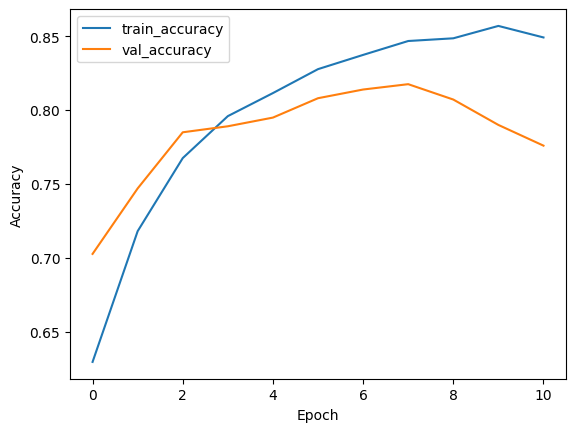

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Entrenar el modelo
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Visualizar la historia de entrenamiento
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


U-Net 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Definir la arquitectura U-Net
def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dense = Dense(2, activation='softmax')(flatten)

    # Modelo final
    model = Model(inputs=inputs, outputs=dense)
    return model

# Crear el modelo U-Net
model = unet()

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
701/701 [==============================] - 124s 168ms/step - loss: 2.9817 - accuracy: 0.6122 - val_loss: 1.0738 - val_accuracy: 0.6107
Epoch 2/50
701/701 [==============================] - 119s 170ms/step - loss: 0.8429 - accuracy: 0.6890 - val_loss: 0.9472 - val_accuracy: 0.6433
Epoch 3/50
701/701 [==============================] - 121s 173ms/step - loss: 0.6250 - accuracy: 0.7270 - val_loss: 0.6441 - val_accuracy: 0.7257
Epoch 4/50
701/701 [==============================] - 121s 173ms/step - loss: 0.4836 - accuracy: 0.7779 - val_loss: 0.5035 - val_accuracy: 0.7777
Epoch 5/50
701/701 [==============================] - 121s 173ms/step - loss: 0.4310 - accuracy: 0.8041 - val_loss: 0.6674 - val_accuracy: 0.7311
Epoch 6/50
701/701 [==============================] - 120s 172ms/step - loss: 0.3860 - accuracy: 0.8282 - val_loss: 0.3883 - val_accuracy: 0.8289
Epoch 7/50
701/701 [==============================] - 121s 173ms/step - loss: 0.4696 - accuracy: 0.7919 - val_loss: 0.8467 -

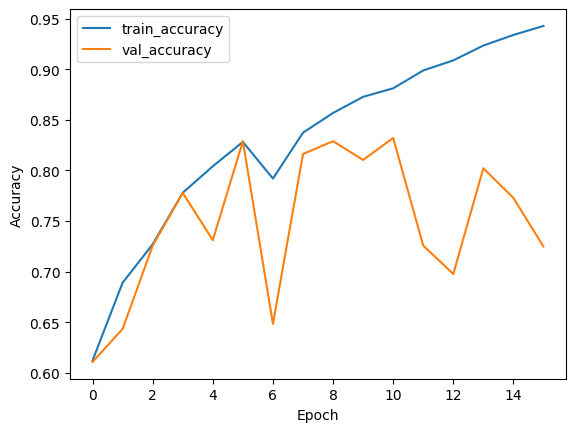

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Entrenar el modelo
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Visualizar la historia de entrenamiento
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


U-Net 3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Definir la arquitectura U-Net
def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dropout = Dropout(0.5)(flatten)
    dense = Dense(2, activation='softmax')(dropout)

    # Modelo final
    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
701/701 [==============================] - 130s 174ms/step - loss: 4.2747 - accuracy: 0.5855 - val_loss: 1.5860 - val_accuracy: 0.6062
Epoch 2/50
701/701 [==============================] - 123s 175ms/step - loss: 0.8866 - accuracy: 0.6373 - val_loss: 0.6007 - val_accuracy: 0.6532
Epoch 3/50
701/701 [==============================] - 123s 175ms/step - loss: 0.5709 - accuracy: 0.7170 - val_loss: 0.5169 - val_accuracy: 0.7510
Epoch 4/50
701/701 [==============================] - 123s 175ms/step - loss: 0.5097 - accuracy: 0.7553 - val_loss: 0.5099 - val_accuracy: 0.7628
Epoch 5/50
701/701 [==============================] - 122s 174ms/step - loss: 0.4966 - accuracy: 0.7631 - val_loss: 0.5789 - val_accuracy: 0.7216
Epoch 6/50
701/701 [==============================] - 123s 175ms/step - loss: 0.4737 - accuracy: 0.7746 - val_loss: 0.4772 - val_accuracy: 0.7818
Epoch 7/50
701/701 [==============================] - 122s 174ms/step - loss: 0.4370 - accuracy: 0.7974 - val_loss: 0.4773 -

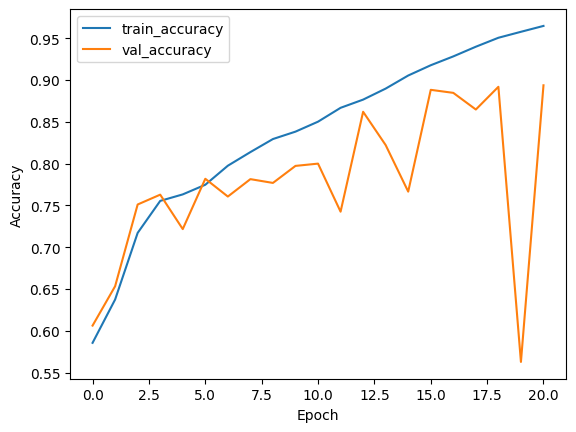

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

U-Net 4

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    # Codificación
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)

    # Decodificación
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv7)
    conv7 = BatchNormalization()(conv7)

    # Capa de salida
    flatten = Flatten()(conv7)
    dropout = Dropout(0.6)(flatten)
    dense = Dense(2, activation='softmax')(dropout)


    model = Model(inputs=inputs, outputs=dense)
    return model


model = unet()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
701/701 [==============================] - 150s 204ms/step - loss: 2.8992 - accuracy: 0.5911 - val_loss: 1.1928 - val_accuracy: 0.6288
Epoch 2/50
701/701 [==============================] - 146s 208ms/step - loss: 1.1232 - accuracy: 0.6405 - val_loss: 0.9333 - val_accuracy: 0.7144
Epoch 3/50
701/701 [==============================] - 147s 209ms/step - loss: 0.9303 - accuracy: 0.6869 - val_loss: 0.9215 - val_accuracy: 0.6695
Epoch 4/50
701/701 [==============================] - 148s 211ms/step - loss: 0.8280 - accuracy: 0.7288 - val_loss: 0.8385 - val_accuracy: 0.7402
Epoch 5/50
701/701 [==============================] - 148s 211ms/step - loss: 0.7335 - accuracy: 0.7596 - val_loss: 0.7136 - val_accuracy: 0.7678
Epoch 6/50
701/701 [==============================] - 147s 210ms/step - loss: 0.6427 - accuracy: 0.7878 - val_loss: 0.7587 - val_accuracy: 0.6840
Epoch 7/50
701/701 [==============================] - 148s 211ms/step - loss: 0.5693 - accuracy: 0.8097 - val_loss: 0.6989 -

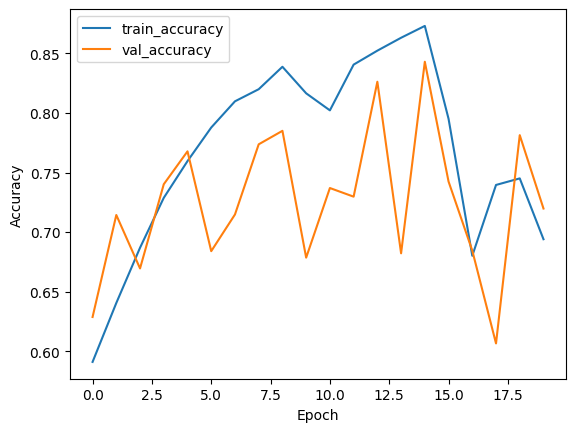

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Inception Net (GoogleNet)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Dense, Flatten, AveragePooling2D
from tensorflow.keras.models import Model

def inception_module(x, filters):
    # Convolution 1x1
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    # Convolution 3x3
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Convolution 5x5
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), padding='same', activation='relu')(x)

    # Max pooling
    max_pooling = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    max_pooling_conv = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(max_pooling)

    # Concatenate filters
    concatenated = concatenate([conv1x1, conv3x3, conv5x5, max_pooling_conv], axis=-1)

    return concatenated

def inception_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, filters=[64, 128, 32, 32])
    x = inception_module(x, filters=[128, 192, 96, 64])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, filters=[192, 208, 48, 64])
    x = inception_module(x, filters=[160, 224, 64, 64])
    x = inception_module(x, filters=[128, 256, 64, 64])
    x = inception_module(x, filters=[112, 288, 64, 64])
    x = inception_module(x, filters=[256, 320, 128, 128])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Flatten
    x = Flatten()(x)

    # Dropout
    x = Dropout(0.4)(x)

    # Dense layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (64, 64, 1)
num_classes = 2


model = inception_net(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_62 (Conv2D)          (None, 32, 32, 64)           3200      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 64)           0         ['conv2d_62[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_63 (Conv2D)          (None, 16, 16, 64)           4160      ['max_pooling2d_22[0][0]

Epoch 1/20
1401/1401 [==============================] - 70s 35ms/step - loss: 1.8701 - accuracy: 0.6571 - val_loss: 0.5746 - val_accuracy: 0.6904
Epoch 2/20
1401/1401 [==============================] - 45s 32ms/step - loss: 0.5071 - accuracy: 0.7500 - val_loss: 0.4777 - val_accuracy: 0.7723
Epoch 3/20
1401/1401 [==============================] - 44s 31ms/step - loss: 0.4578 - accuracy: 0.7845 - val_loss: 0.4461 - val_accuracy: 0.7845
Epoch 4/20
1401/1401 [==============================] - 44s 32ms/step - loss: 0.4260 - accuracy: 0.8029 - val_loss: 0.3989 - val_accuracy: 0.8171
Epoch 5/20
1401/1401 [==============================] - 45s 32ms/step - loss: 0.4072 - accuracy: 0.8132 - val_loss: 0.3690 - val_accuracy: 0.8311
Epoch 6/20
1401/1401 [==============================] - 44s 32ms/step - loss: 0.3989 - accuracy: 0.8197 - val_loss: 0.4036 - val_accuracy: 0.8203
Epoch 7/20
1401/1401 [==============================] - 44s 31ms/step - loss: 0.3868 - accuracy: 0.8251 - val_loss: 0.3745 -

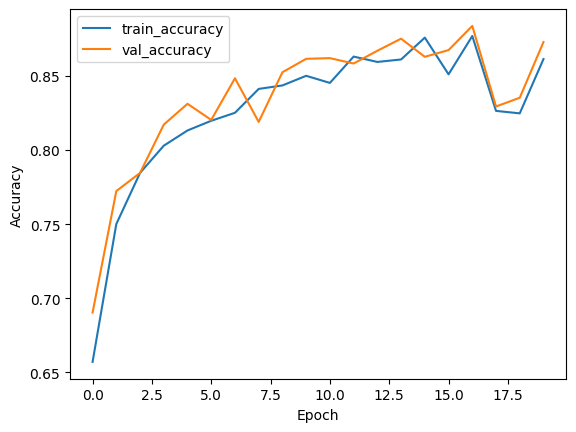

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test, y_test))

# Visualizar la historia de entrenamiento
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")

ruta_modelo = "/content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model"

model.save(os.path.join(ruta_modelo, "model_InceptionNet.h5"))
print("Modelo guardado exitosamente en", ruta_modelo)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado exitosamente en /content/drive/MyDrive/Master IA^3/TFM/Sistema de detección prematura de cáncer de tórax/Model


#### Inception Net - other parameters

Epoch 1/50
1401/1401 [==============================] - 65s 35ms/step - loss: 1.2502 - accuracy: 0.6768 - val_loss: 0.4891 - val_accuracy: 0.7560
Epoch 2/50
1401/1401 [==============================] - 44s 31ms/step - loss: 0.4908 - accuracy: 0.7626 - val_loss: 0.4639 - val_accuracy: 0.7832
Epoch 3/50
1401/1401 [==============================] - 44s 31ms/step - loss: 0.4527 - accuracy: 0.7861 - val_loss: 0.4335 - val_accuracy: 0.7976
Epoch 4/50
1401/1401 [==============================] - 45s 32ms/step - loss: 0.4228 - accuracy: 0.8037 - val_loss: 0.3891 - val_accuracy: 0.8148
Epoch 5/50
1401/1401 [==============================] - 44s 32ms/step - loss: 0.4155 - accuracy: 0.8091 - val_loss: 0.4057 - val_accuracy: 0.8112
Epoch 6/50
1401/1401 [==============================] - 45s 32ms/step - loss: 0.3879 - accuracy: 0.8244 - val_loss: 0.4565 - val_accuracy: 0.8031
Epoch 7/50
1401/1401 [==============================] - 45s 32ms/step - loss: 0.3814 - accuracy: 0.8279 - val_loss: 0.5676 -

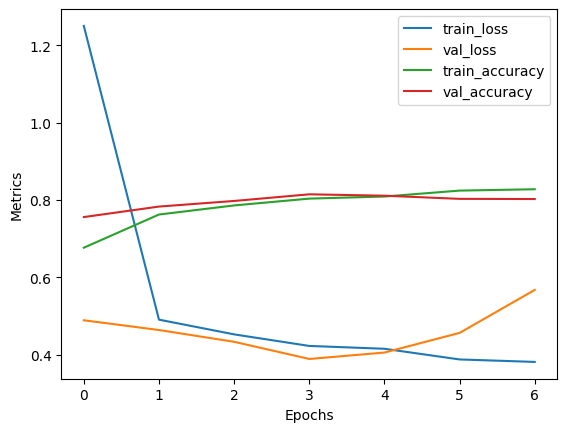

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 32, 32, 64)           3200      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 16, 16, 64)           0         ['conv2d_31[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_32 (Conv2D)          (None, 16, 16, 64)           4160      ['max_pooling2d_11[0][0]

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Dense, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def inception_module(x, filters):
    # Convolution 1x1
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    # Convolution 3x3
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Convolution 5x5
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), padding='same', activation='relu')(x)

    # Max pooling
    max_pooling = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    max_pooling_conv = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(max_pooling)

    # Concatenate filters
    concatenated = concatenate([conv1x1, conv3x3, conv5x5, max_pooling_conv], axis=-1)

    return concatenated

def inception_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, filters=[64, 128, 32, 32])
    x = inception_module(x, filters=[128, 192, 96, 64])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, filters=[192, 208, 48, 64])
    x = inception_module(x, filters=[160, 224, 64, 64])
    x = inception_module(x, filters=[128, 256, 64, 64])
    x = inception_module(x, filters=[112, 288, 64, 64])
    x = inception_module(x, filters=[256, 320, 128, 128])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Flatten
    x = Flatten()(x)

    # Dropout
    x = Dropout(0.4)(x)

    # Dense layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (64, 64, 1)
num_classes = 2

model = inception_net(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


model.summary()


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dropout, Dense

input_layer = Input(shape=(64, 64, 1))

conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)

flatten = Flatten()(pool3)
dropout1 = Dropout(0.5)(flatten)
dense1 = Dense(512, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(2, activation='softmax')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_data=(X_test, y_test))


plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### HeatMaps

1/1 [==============================] - 0s 87ms/step


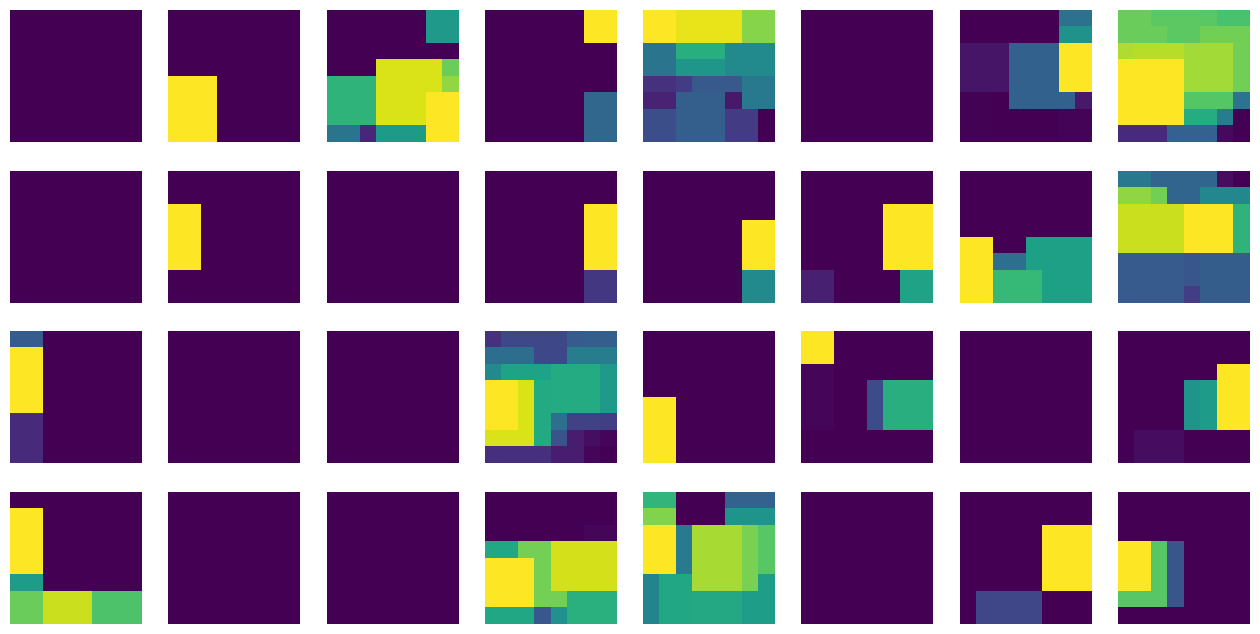

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Crear un modelo intermedio que toma como entrada las imágenes y devuelve las salidas de las capas convolucionales
activation_model = Model(inputs=model.input, outputs=model.layers[6].output)
X_sample = X_test[0]
# Obtener las activaciones de las capas convolucionales para una imagen de ejemplo
activations = activation_model.predict(X_sample.reshape(1, 64, 64, 1))


plt.figure(figsize=(16, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()
